### Data cleaning and removal of redundant data

In [1]:
import numpy as np
import pandas as pd

# Functions from basic_functions
def _intersectLists(list1, list2):
    intersectedList = [int(e) for e in list(set(list1).intersection(set(list2)))]
    intersectedList.sort()
    intersectedList = [str(e) for e in intersectedList]
    return intersectedList

def listify(stringOfIDs):
    stringOfIDs = str(stringOfIDs)
    lst = stringOfIDs[1:-1]
    lst = lst.split(", ")
    lst = [l[1:-1] for l in lst]
    return lst

In [41]:
#For plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

In [19]:
#We set some global constants
minChannel = 14
maxChannel = 36

pathToConstraints = "/Users/haakonhr/station-repacking/data/raw/Interference_Paired.csv"
pathToDomains = "/Users/haakonhr/station-repacking/data/raw/Domain.csv"

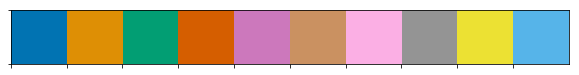

In [87]:
current_palette = sns.color_palette("colorblind", 10)
sns.set_palette(current_palette)
sns.palplot(current_palette)

In [88]:
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rc('text', usetex=True)
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
mpl.rcParams.update({'font.size': 13})

## Domains

In [6]:
myColNamesLists = ["type", "targetID", "domain"]

domains = pd.read_table(pathToDomains, header=None, names=["type"])
domains[myColNamesLists] = domains.type.str.split(",", n=2, expand=True)
domains.domain = domains.domain.str.split(",")

domains = domains.drop("type",1)
domains = domains.set_index("targetID", drop=True)
domains.head()

domain
targetID                                                   
87        [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...
125       [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...
126       [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...
131       [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...
144       [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...

In [7]:
domains.shape

(2990, 1)

In [8]:
vhf = domains
vhf = vhf["domain"].apply(_intersectLists, list2 = [str(i) for i in range(1,13)])
vhf.head()

targetID
87     [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
125    [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
126    [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
131    [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
144    [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Name: domain, dtype: object

In [9]:
len(vhf[len(vhf.values) == 0])

11

# UHF only stations

In [10]:
uhf = domains
uhf["domain"] = uhf["domain"].apply(_intersectLists, list2 = [str(i) for i in range(14,52)])
uhf.head()

domain
targetID                                                   
87        [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
125       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
126       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
131       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
144       [14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 2...

In [11]:
len(uhf[uhf["domain"].apply(len) > 0])

2058

There are 932 stations that are VHF only.

Only channels 14 to 36 are of interest so the remaining channels are removed from the domains.

In [12]:
domains["domain"] = domains["domain"].apply(_intersectLists, list2 = [str(i) for i in range(minChannel, maxChannel+1)])
domains.head()

domain
targetID                                                   
87        [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
125       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
126       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
131       [14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 2...
144       [14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 2...

In [13]:
len(domains[domains["domain"].apply(len) == 0])

932

There are 932 stations that are not relevant as they are not UHF stations, i.e. they do not transmit on any of the channels available for re-packing

In [14]:
domains = domains[domains["domain"].apply(len) > 0]
domains.shape

(2058, 1)

The pruned constraints are then written to file, but note that lookups might fail if there is some corrupt data in the instances.

In [15]:
lens = domains["domain"].apply(len)
lens.describe()

count    2058.000000
mean       21.514577
std         3.136659
min         1.000000
25%        21.000000
50%        23.000000
75%        23.000000
max        23.000000
Name: domain, dtype: float64

In [16]:
prep_plot = lens.value_counts()
prep_plot.index

Int64Index([23, 21, 20, 19, 22, 15, 18, 16, 17, 8, 12, 9, 13, 5, 10, 6, 1, 14,
            3, 11, 4],
           dtype='int64')

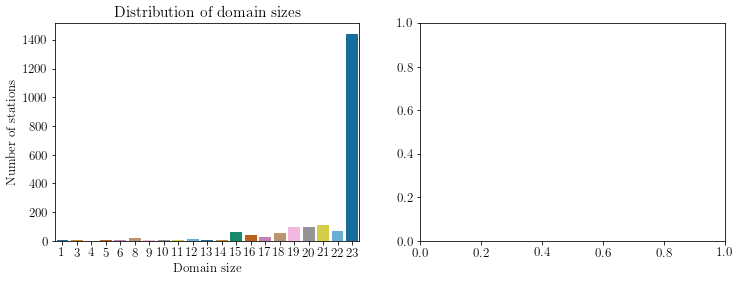

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.barplot(x = list(prep_plot.index),
                 y = list(prep_plot.values),
                 palette=current_palette,
                ax=ax[0])
ax[0].set(xlabel="Domain size", ylabel="Number of stations")
ax[0].set_title("Distribution of domain sizes")
#plt.savefig("../reports/figures/distribution_of_domains.png")
plt.show()

The following histrogram shows the distribution of domains and the len of domains. One sees that more than half of the stations have all the channels available, but there is also a non-significant fraction that has very few.

In [56]:
prep_plot_pruned = lens[lens < 23].value_counts()
sns.barplot(x = list(prep_plot_pruned.index),
                 y = list(prep_plot_pruned.values),
                 palette=current_palette,
                 ax=ax[1])
ax[1].set(xlabel="Domain size")
ax[1].set_title("Distribution of domain sizes less than 23")
#plt.savefig("../reports/figures/distribution_of_domains_pruned.png")
plt.show()

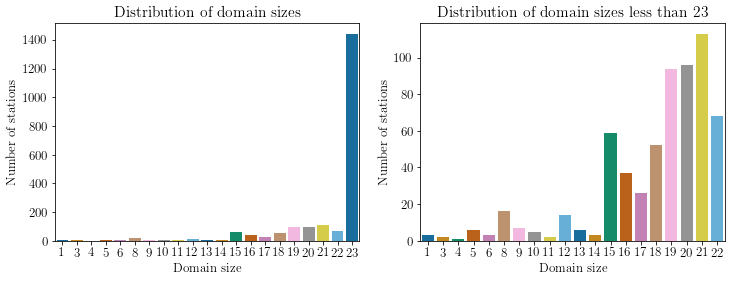

In [57]:
fig

In [58]:
fig.savefig("domain_distribution.pdf")

In [160]:
#domains.to_csv("/Users/haakonhr/station-repacking/data/interim/domains_pruned.csv", header = True, index = True)

## Interference constraints

In [112]:
myColNames = ["interferenceType", "targetChannel", "interferingChannel", "targetID", "interferingIDs"]
constraints = pd.read_table(pathToConstraints, header=None, names=["interferenceType"])

#Manipulate so that the interferingIDs become a list
constraints[myColNames] = constraints.interferenceType.str.split(",", n=4, expand=True)
constraints.interferingIDs = constraints.interferingIDs.str.split(",")
constraints.loc[:, "targetChannel"] = constraints["targetChannel"].apply(int)
constraints.loc[:, "interferingChannel"] = constraints["interferingChannel"].apply(int)

constraints.head()

interferenceType  targetChannel  interferingChannel targetID  \
0               CO              2                   2       87   
1               CO              2                   2      125   
2               CO              2                   2      126   
3               CO              2                   2      131   
4               CO              2                   2      144   

                                      interferingIDs  
0  [38214, 50194, 50205, 66414, 72361, 79258, 86532]  
1  [126, 10032, 14040, 17683, 18287, 20476, 22685...  
2  [125, 14040, 18287, 20476, 22685, 23074, 24514...  
3  [4108, 5802, 6601, 6744, 7726, 7727, 9881, 100...  
4  [148, 749, 6669, 8564, 9754, 9781, 10188, 1024...

Only the interference constraints concerning channels 14-36, 23 in total, are of interesting as the lower bands (1-13) belongs to a different band of channels that were easy to solve in practice. The high frequency band or the UHF band, containing channels 14-49, was the challening one. The clearing target was set such that the available UHF channels for repacking were channels 14-36. 

In [113]:
constraints["interferingChannel"].unique()

array([ 2,  4,  3,  5,  6,  7,  9,  8, 10, 11, 12, 13, 14, 16, 15, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 38, 40, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [114]:
constraints.shape

(273131, 5)

Each row of the of the interference_paired.csv file describes several interference constraints, one per station in the list of interfering stations. However, each interference constraint is described twice as each station that appears in the list of interfering stations also appears as the target station in another row. The order does not matter (this is proved in chapter 2 of the thesis)

Now we compute the number of interference constraints in the different bands (LVHF, HVHF, UHF, target between channel 14-36 and interfering channel between 37-51, channel 14-36)

In [115]:
# Compute the number of pairwise interference constraints
l = [len(i) for i in constraints[constraints["targetChannel"].between(1,6)]["interferingIDs"].values if i]
int(sum(l)/2)

328952

In [116]:
# Compute the number of pairwise interference constraints
l = [len(i) for i in constraints[constraints["targetChannel"].between(7,13)]["interferingIDs"].values if i]
int(sum(l)/2)

485093

In [121]:
# Compute the number of pairwise interference constraints
l = [len(i) for i in constraints[constraints["targetChannel"].between(14,51)]["interferingIDs"].values if i]
int(sum(l)/2)

1880085

In [125]:
# Compute the number of pairwise interference constraints
l = [len(i) for i in constraints.loc[(constraints["targetChannel"].between(14,36)) &
                                 (constraints["interferingChannel"].between(14,36) == False), "interferingIDs"].values if i]
int(sum(l)/2)

22

In [126]:
# Compute the number of pairwise interference constraints
l = [len(i) for i in constraints["interferingIDs"].values if i]
int(sum(l)/2)

2694130

In [127]:
constraints[["targetChannel", "interferingChannel"]] = constraints[["targetChannel", "interferingChannel"]].apply(pd.to_numeric)
constraints[(constraints["targetChannel"].between(minChannel,maxChannel) == False) | (constraints["interferingChannel"].between(minChannel,maxChannel) == False)].shape

(144902, 5)

In [128]:
1880085+485093+328952

2694130

The total number of interference constraints between stationsin the US is about 2.7m.

Now the set of constraints is pruned to consider only constraints on channels 14 to 36, the channels available for repacking in the final run of the FCC Incentive Auction.

In [129]:
#We remove the rows not concerning the relevant channels
constraints[["targetChannel", "interferingChannel"]] = constraints[["targetChannel", "interferingChannel"]].apply(pd.to_numeric)
constraints = constraints[(constraints["targetChannel"].between(minChannel, maxChannel)) & (constraints["interferingChannel"].between(minChannel, maxChannel))]

In [130]:
constraints.shape

(128229, 5)

In [131]:
l = [len(i) for i in constraints["interferingIDs"].values if i]
int(sum(l)/2)

1167145

The number of relevant constraints is therefore drastically reduced from 2.7m to a bit more than 1.1m

In [134]:
crit_empty = constraints["interferingIDs"].isna()

In [138]:
constraints.drop(constraints[crit_empty].index, inplace=True)

Then every row that does not correspond to a constraint, i.e. whenever the list of interferingIDs is empty. Any row which contains a station which has a channel that is always available in its domain can therefore be removed from any instance and is therefore redundant.

Even though these rows do not describe constraints, it is kept to avoid missing information in case of lookups and so on. It can be useful to have a row to find when a station has a channel in its domain which has no interfering stations.

One can further prune the constraints by removing the rows corresponding to target stations that do not have any of the channels 14 to 36 in its domain or the rows where the target channel is not in the domain of the target station.

In [78]:
stationIsUHFCrit = constraints["targetID"].isin(set(domains.index.values))
len(set(domains.index.values))

2058

In [79]:
constraints[stationIsUHFCrit].shape == constraints.shape

True

Th removal of non-UHF stations from the constraints are already taken care of by restricting the target and interfering channels to be between 14 and 36, as can be seen from the above statement being true.

In [139]:
#This block removes all redundant constraints where the target channel is not in the domain
#of the target station (targetID).
for constraint in constraints.itertuples():
    if str(constraint.targetChannel) not in domains.loc[constraint.targetID, "domain"]:
        #print(constraint.targetChannel, " is not in the domain of ", constraint.targetID
        #      , ": ", domains.loc[constraint.targetID, "domain"])
        constraints.drop(constraint.Index, inplace=True)
        
constraints.shape      

(119092, 5)

One can also intersect the list of interfering stations with the set of stations that have the target channel in its domain

In [140]:
for constraint in constraints.itertuples():
    if constraint.interferingIDs:
        intList = _intersectLists(constraint.interferingIDs, list(domains.index.values))
        if intList != constraint.interferingIDs:
            print("Intersection actually removes stations")
            print(set(constraints.interferingIDs) - set(_intersectLists(constraints.interferingIDs, list(domains.index.values))))

However, this is already taken care of, as it should be, in the interference constraints the FCC has made available.

In [172]:
# Write out constraints
#constraints.to_csv("/Users/haakonhr/station-repacking/data/interim/interference_constraints_pruned.csv")

We now plot the distribution

In [94]:
constraints.head()

interferenceType  targetChannel  interferingChannel targetID  \
68072               CO             14                  14       87   
68073               CO             14                  14      125   
68074               CO             14                  14      126   
68075               CO             14                  14      131   
68076               CO             14                  14      144   

                                          interferingIDs  
68072         [25382, 50170, 50182, 66222, 77480, 86532]  
68073  [126, 14040, 20476, 24514, 29455, 35037, 35883...  
68074  [125, 14040, 20476, 24514, 29455, 35037, 35883...  
68075  [4108, 5802, 6601, 6744, 7726, 7727, 9881, 100...  
68076  [6669, 8564, 9754, 9781, 12522, 12895, 17433, ...

In [141]:
constraints["interferenceType"].value_counts()

CO       43726
ADJ-1    37093
ADJ+1    36908
ADJ-2      693
ADJ+2      672
Name: interferenceType, dtype: int64

In [143]:
num_of_pairwise_constraints = constraints.groupby(
    "interferenceType")["interferingIDs"].apply(
    lambda x: sum([len(i) for i in x]))

In [144]:
num_of_pairwise_constraints

interferenceType
ADJ+1     369638
ADJ+2        924
ADJ-1     374834
ADJ-2        924
CO       1400723
Name: interferingIDs, dtype: int64

In [164]:
[i/sum(num_of_pairwise_constraints.values()) for i in list(
    num_of_pairwise_constraints.values())]

[0.1721614331897405,
 0.00043035933607291516,
 0.1745815058198648,
 0.00043035933607291516,
 0.6523963423182488]

## Miscellaneous

In [190]:
#This block removes the constraints that are trivially unrestricted, in the sense
#that they have a channel in their domain without any interference

unconstrainedCriteria = constraints["interferingIDs"].isnull() == True
unconstrainedStations = constraints[unconstrainedCriteria]["targetID"]
#print(len(unconstrainedStations), "\n", unconstrainedStations)

stationConstrained = constraints["targetID"].isin(unconstrainedStations) == False
constraints[unconstrainedCriteria].shape

(551, 5)

The last number, 49, corresponds with the number of unconstrained stations when the domains were not considered.

In [18]:
counter = 0
for entry in dfInterference.itertuples():
    if entry.interferenceType == "ADJ+1" or entry.interferenceType == "ADJ-1":
        temp = df.loc[df["targetID"] == entry.targetID]
        temp = temp.loc[temp["targetChannel"] == entry.targetChannel]
        counter += 1
        if temp.loc[temp["interferenceType"] == "CO"].empty:
            print(entry)
            print("Something is wrong")
            break
        
        if counter % 1000 == 0:
            print(entry.interferenceType)
            print(temp)
            
    if entry.interferenceType == "ADJ+2" or entry.interferenceType == "ADJ-2":
        temp = df.loc[df["targetID"] == entry.targetID]
        temp = temp.loc[temp["targetChannel"] == entry.targetChannel]
        counter += 1
        if temp.loc[temp["interferenceType"] == "ADJ+1"].empty and temp.loc[temp["interferenceType"] == "ADJ-1"].empty:
            print(entry)
            print("Something is wrong")
            break
        
        if counter % 100 == 0:
            print(entry.interferenceType)
            print(temp)
        

NameError: name 'df' is not defined

All seems to be good, meaning that ADJ+/-2 implies ADJ+/-1 implies CO constraints.

Now we want to see whether the constraints are symmetric, i.e if (1,1) interfering with (2,2) implies that (1,2) interferes with (2,1).

In [21]:
dfInterferenceADJ1 = dfInterference.loc[(dfInterference["interferenceType"] == "ADJ+1") | (dfInterference["interferenceType"] == "ADJ-1")]
dfInterferenceADJ2 = dfInterference.loc[(dfInterference["interferenceType"] == "ADJ+2") | (dfInterference["interferenceType"] == "ADJ-2")]

The fact that there is an odd number of ADJ+/-2 interference constraints already imply that they cannot be symmetric since there must be at least interference constraint that only interferes one way.

In [52]:
numberOfAsymmetries = 0

for row in dfInterferenceADJ1.itertuples():
    #print(row)
    for station in row.interferingIDs:
        temp = dfInterferenceADJ1.loc[(dfInterferenceADJ1["targetID"] == station) & (dfInterferenceADJ1["targetChannel"] == row.interferingChannel)]
        if row.targetID not in temp.interferingIDs.tolist()[0]:
            numberOfAsymmetries += 1
            #print(row.targetID)
            #print(temp.interferingIDs.tolist())
            #interferingIDs = temp.interferingIDs.tolist()
            #print(interferingIDs[0])
            #Something goes wrong with the types here.. Another day....!
            #print(row.targetID in temp.interferingIDs)
            #print(type(row.targetID))
            #print(type(interferingIDs[0][0]))
            #print(row.targetID in interferingIDs)
            print("Asymmetry: ", station, " and ", row.targetID)

print(numberOfAsymmetries)

Asymmetry:  63158  and  125
Asymmetry:  53819  and  131
Asymmetry:  35882  and  144
Asymmetry:  35911  and  144
Asymmetry:  48836  and  144
Asymmetry:  70161  and  146
Asymmetry:  3072  and  147
Asymmetry:  53115  and  147
Asymmetry:  74170  and  147
Asymmetry:  68401  and  259
Asymmetry:  34204  and  411
Asymmetry:  21252  and  413
Asymmetry:  69114  and  414
Asymmetry:  14326  and  415
Asymmetry:  55203  and  416
Asymmetry:  34202  and  417
Asymmetry:  28468  and  418
Asymmetry:  1000217  and  455
Asymmetry:  715  and  591
Asymmetry:  68519  and  2784
Asymmetry:  416  and  3133
Asymmetry:  40902  and  3133
Asymmetry:  17544  and  3359
Asymmetry:  7908  and  3646
Asymmetry:  51101  and  3659
Asymmetry:  67766  and  3659
Asymmetry:  73999  and  3661
Asymmetry:  58341  and  4077
Asymmetry:  55106  and  4108
Asymmetry:  71580  and  4108
Asymmetry:  70021  and  4149
Asymmetry:  35090  and  4190
Asymmetry:  51102  and  4326
Asymmetry:  60549  and  4328
Asymmetry:  31570  and  4353
Asymmetr

Asymmetry:  74070  and  25544
Asymmetry:  13594  and  25682
Asymmetry:  13595  and  25682
Asymmetry:  25686  and  25684
Asymmetry:  18285  and  25685
Asymmetry:  71121  and  25932
Asymmetry:  71427  and  26025
Asymmetry:  74098  and  26025
Asymmetry:  55083  and  26231
Asymmetry:  60549  and  26231
Asymmetry:  60464  and  26304
Asymmetry:  67140  and  27245
Asymmetry:  70699  and  27245
Asymmetry:  60888  and  27501
Asymmetry:  67002  and  28010
Asymmetry:  16363  and  28311
Asymmetry:  12896  and  28324
Asymmetry:  13200  and  28324
Asymmetry:  22108  and  28462
Asymmetry:  25040  and  28462
Asymmetry:  73905  and  28462
Asymmetry:  66536  and  28476
Asymmetry:  47929  and  28480
Asymmetry:  55350  and  28480
Asymmetry:  61111  and  28480
Asymmetry:  73318  and  28480
Asymmetry:  74197  and  28480
Asymmetry:  2175  and  28954
Asymmetry:  18410  and  28954
Asymmetry:  58342  and  28954
Asymmetry:  61573  and  29000
Asymmetry:  66285  and  29706
Asymmetry:  70414  and  29712
Asymmetry: 

Asymmetry:  35883  and  57219
Asymmetry:  21252  and  57274
Asymmetry:  16950  and  57456
Asymmetry:  35823  and  57884
Asymmetry:  36607  and  57884
Asymmetry:  69396  and  57884
Asymmetry:  69582  and  57884
Asymmetry:  4688  and  57907
Asymmetry:  10259  and  57908
Asymmetry:  65943  and  57908
Asymmetry:  23918  and  58262
Asymmetry:  4328  and  58827
Asymmetry:  12896  and  58835
Asymmetry:  13200  and  58835
Asymmetry:  25065  and  59438
Asymmetry:  39738  and  59438
Asymmetry:  8532  and  59441
Asymmetry:  41074  and  59441
Asymmetry:  71218  and  59442
Asymmetry:  41892  and  59852
Asymmetry:  6744  and  60018
Asymmetry:  10073  and  60018
Asymmetry:  12171  and  60018
Asymmetry:  61702  and  60018
Asymmetry:  5319  and  60534
Asymmetry:  9425  and  60536
Asymmetry:  35101  and  60539
Asymmetry:  41674  and  60539
Asymmetry:  42665  and  60539
Asymmetry:  73983  and  60539
Asymmetry:  60637  and  60549
Asymmetry:  65944  and  60552
Asymmetry:  6048  and  60553
Asymmetry:  11559

Asymmetry:  10318  and  73964
Asymmetry:  21252  and  73964
Asymmetry:  74151  and  73964
Asymmetry:  6476  and  73982
Asymmetry:  36117  and  73983
Asymmetry:  34174  and  73999
Asymmetry:  71508  and  74034
Asymmetry:  73375  and  74034
Asymmetry:  78908  and  74034
Asymmetry:  12793  and  74070
Asymmetry:  72106  and  74070
Asymmetry:  10259  and  74091
Asymmetry:  60559  and  74112
Asymmetry:  61504  and  74112
Asymmetry:  73264  and  74156
Asymmetry:  53115  and  74170
Asymmetry:  43197  and  74192
Asymmetry:  71357  and  74192
Asymmetry:  20818  and  74197
Asymmetry:  1000222  and  74211
Asymmetry:  3072  and  74215
Asymmetry:  20818  and  74215
Asymmetry:  65680  and  74417
Asymmetry:  73107  and  74417
Asymmetry:  60654  and  74419
Asymmetry:  9908  and  74420
Asymmetry:  39884  and  74464
Asymmetry:  60675  and  77063
Asymmetry:  190120  and  77063
Asymmetry:  35666  and  77480
Asymmetry:  38214  and  77480
Asymmetry:  67999  and  77480
Asymmetry:  83180  and  77483
Asymmetry:

Asymmetry:  72359  and  11911
Asymmetry:  29086  and  11913
Asymmetry:  60637  and  12144
Asymmetry:  71278  and  12279
Asymmetry:  72945  and  12279
Asymmetry:  17399  and  12427
Asymmetry:  710  and  12472
Asymmetry:  60165  and  12497
Asymmetry:  12279  and  12498
Asymmetry:  52408  and  12498
Asymmetry:  168237  and  12498
Asymmetry:  60555  and  12499
Asymmetry:  74197  and  12499
Asymmetry:  74215  and  12499
Asymmetry:  167543  and  12499
Asymmetry:  23422  and  12522
Asymmetry:  51517  and  12522
Asymmetry:  32176  and  12523
Asymmetry:  40058  and  12523
Asymmetry:  61011  and  12793
Asymmetry:  10521  and  12855
Asymmetry:  41375  and  12855
Asymmetry:  61702  and  12855
Asymmetry:  12896  and  12895
Asymmetry:  13200  and  12895
Asymmetry:  23918  and  13206
Asymmetry:  63329  and  13206
Asymmetry:  9425  and  13456
Asymmetry:  74170  and  13602
Asymmetry:  68393  and  13924
Asymmetry:  1222  and  13960
Asymmetry:  51991  and  13991
Asymmetry:  38430  and  14000
Asymmetry:  

Asymmetry:  29234  and  47906
Asymmetry:  38430  and  47906
Asymmetry:  55083  and  47906
Asymmetry:  51864  and  48406
Asymmetry:  14322  and  48477
Asymmetry:  29547  and  48608
Asymmetry:  69446  and  48662
Asymmetry:  70699  and  48662
Asymmetry:  17012  and  48666
Asymmetry:  69332  and  48666
Asymmetry:  57292  and  48693
Asymmetry:  10802  and  48772
Asymmetry:  71111  and  48772
Asymmetry:  71425  and  48772
Asymmetry:  74098  and  48772
Asymmetry:  74174  and  48772
Asymmetry:  35418  and  48813
Asymmetry:  35910  and  48836
Asymmetry:  56528  and  48836
Asymmetry:  24570  and  48837
Asymmetry:  8214  and  49153
Asymmetry:  70097  and  49157
Asymmetry:  52628  and  49240
Asymmetry:  9781  and  49324
Asymmetry:  5319  and  49326
Asymmetry:  9781  and  49326
Asymmetry:  41671  and  49803
Asymmetry:  74007  and  49803
Asymmetry:  53541  and  50044
Asymmetry:  2566  and  50170
Asymmetry:  8241  and  50591
Asymmetry:  70423  and  50782
Asymmetry:  35611  and  51189
Asymmetry:  3559

Asymmetry:  12793  and  70149
Asymmetry:  61009  and  70149
Asymmetry:  73706  and  70482
Asymmetry:  81507  and  70482
Asymmetry:  86534  and  70482
Asymmetry:  49421  and  70491
Asymmetry:  13595  and  70493
Asymmetry:  6601  and  70649
Asymmetry:  62388  and  70649
Asymmetry:  41225  and  70651
Asymmetry:  53116  and  70651
Asymmetry:  23960  and  70689
Asymmetry:  35611  and  70900
Asymmetry:  70649  and  71085
Asymmetry:  12498  and  71111
Asymmetry:  32334  and  71111
Asymmetry:  71428  and  71111
Asymmetry:  71121  and  71127
Asymmetry:  5360  and  71221
Asymmetry:  74138  and  71221
Asymmetry:  10221  and  71278
Asymmetry:  68545  and  71278
Asymmetry:  72342  and  71278
Asymmetry:  10521  and  71293
Asymmetry:  35575  and  71293
Asymmetry:  41375  and  71293
Asymmetry:  69338  and  71293
Asymmetry:  720  and  71325
Asymmetry:  16539  and  71326
Asymmetry:  43168  and  71326
Asymmetry:  43197  and  71357
Asymmetry:  70021  and  71357
Asymmetry:  60827  and  71363
Asymmetry:  71

Asymmetry:  24582  and  6601
Asymmetry:  74559  and  6601
Asymmetry:  34195  and  6837
Asymmetry:  16363  and  6866
Asymmetry:  65680  and  6870
Asymmetry:  72342  and  6870
Asymmetry:  25685  and  6885
Asymmetry:  4190  and  6900
Asymmetry:  11113  and  6900
Asymmetry:  35418  and  6900
Asymmetry:  2731  and  7143
Asymmetry:  23338  and  7623
Asymmetry:  74216  and  7623
Asymmetry:  168560  and  7675
Asymmetry:  60552  and  7933
Asymmetry:  26602  and  8156
Asymmetry:  64865  and  8156
Asymmetry:  5801  and  8322
Asymmetry:  47707  and  8322
Asymmetry:  71357  and  8653
Asymmetry:  12033  and  8688
Asymmetry:  17012  and  8688
Asymmetry:  69332  and  8688
Asymmetry:  19199  and  9054
Asymmetry:  21536  and  9054
Asymmetry:  13602  and  9610
Asymmetry:  51568  and  9610
Asymmetry:  60560  and  9610
Asymmetry:  63153  and  9610
Asymmetry:  191793  and  9628
Asymmetry:  29086  and  9629
Asymmetry:  42665  and  9635
Asymmetry:  71278  and  9635
Asymmetry:  71427  and  9635
Asymmetry:  741

Asymmetry:  34211  and  34195
Asymmetry:  34202  and  34207
Asymmetry:  34211  and  34207
Asymmetry:  71861  and  34212
Asymmetry:  35908  and  34222
Asymmetry:  57457  and  34439
Asymmetry:  35703  and  34440
Asymmetry:  32176  and  34457
Asymmetry:  40058  and  34457
Asymmetry:  57456  and  34459
Asymmetry:  24508  and  34574
Asymmetry:  58684  and  34868
Asymmetry:  35991  and  35037
Asymmetry:  60637  and  35123
Asymmetry:  50591  and  35189
Asymmetry:  66170  and  35190
Asymmetry:  55528  and  35313
Asymmetry:  60795  and  35313
Asymmetry:  24812  and  35385
Asymmetry:  69114  and  35385
Asymmetry:  70251  and  35385
Asymmetry:  37238  and  35417
Asymmetry:  11910  and  35434
Asymmetry:  22644  and  35500
Asymmetry:  35611  and  35500
Asymmetry:  4148  and  35512
Asymmetry:  18740  and  35512
Asymmetry:  70414  and  35576
Asymmetry:  72618  and  35705
Asymmetry:  9781  and  35841
Asymmetry:  67002  and  35843
Asymmetry:  1000093  and  35862
Asymmetry:  48836  and  35867
Asymmetry:

Asymmetry:  60555  and  63153
Asymmetry:  167543  and  63153
Asymmetry:  9425  and  63154
Asymmetry:  35037  and  63158
Asymmetry:  40250  and  63158
Asymmetry:  60026  and  63865
Asymmetry:  67013  and  63865
Asymmetry:  4190  and  64033
Asymmetry:  11113  and  64033
Asymmetry:  629  and  64352
Asymmetry:  14315  and  64352
Asymmetry:  41230  and  64444
Asymmetry:  42636  and  64444
Asymmetry:  59444  and  64444
Asymmetry:  73107  and  64545
Asymmetry:  27969  and  64548
Asymmetry:  18780  and  64550
Asymmetry:  17012  and  64611
Asymmetry:  69332  and  64611
Asymmetry:  51374  and  64877
Asymmetry:  10205  and  64987
Asymmetry:  10242  and  64987
Asymmetry:  70900  and  64987
Asymmetry:  6870  and  65143
Asymmetry:  412  and  65387
Asymmetry:  13060  and  65387
Asymmetry:  57832  and  65387
Asymmetry:  34445  and  65395
Asymmetry:  34867  and  65395
Asymmetry:  22644  and  65526
Asymmetry:  39665  and  65528
Asymmetry:  77451  and  65528
Asymmetry:  21158  and  65666
Asymmetry:  4062

Asymmetry:  43184  and  136749
Asymmetry:  48521  and  166319
Asymmetry:  24515  and  166331
Asymmetry:  11911  and  166332
Asymmetry:  60675  and  166332
Asymmetry:  168750  and  166510
Asymmetry:  58978  and  167309
Asymmetry:  191101  and  167309
Asymmetry:  3359  and  168094
Asymmetry:  35101  and  168237
Asymmetry:  64352  and  168478
Asymmetry:  9739  and  191340
Asymmetry:  61111  and  191822
Asymmetry:  1000011  and  1000007
Asymmetry:  1000019  and  1000018
Asymmetry:  1000020  and  1000018
Asymmetry:  1500316  and  1000067
Asymmetry:  1500316  and  1000068
Asymmetry:  1000108  and  1000092
Asymmetry:  1000046  and  1000093
Asymmetry:  1000108  and  1000094
Asymmetry:  1000108  and  1000095
Asymmetry:  1000095  and  1000096
Asymmetry:  1000052  and  1000098
Asymmetry:  1000094  and  1000105
Asymmetry:  1000103  and  1000105
Asymmetry:  1000108  and  1000105
Asymmetry:  1000156  and  1000129
Asymmetry:  1000165  and  1000164
Asymmetry:  30303  and  1000175
Asymmetry:  1000174  

Asymmetry:  13929  and  20287
Asymmetry:  168101  and  20590
Asymmetry:  54983  and  20624
Asymmetry:  67022  and  20624
Asymmetry:  69300  and  20624
Asymmetry:  14322  and  20818
Asymmetry:  2424  and  20871
Asymmetry:  59280  and  21254
Asymmetry:  701  and  21258
Asymmetry:  30283  and  21258
Asymmetry:  61007  and  21536
Asymmetry:  61012  and  21536
Asymmetry:  70021  and  21729
Asymmetry:  58978  and  22161
Asymmetry:  5319  and  22201
Asymmetry:  16930  and  22201
Asymmetry:  12896  and  22204
Asymmetry:  13200  and  22204
Asymmetry:  3072  and  22206
Asymmetry:  6048  and  22206
Asymmetry:  33081  and  22206
Asymmetry:  23338  and  22207
Asymmetry:  65670  and  22207
Asymmetry:  12498  and  22211
Asymmetry:  71425  and  22211
Asymmetry:  74098  and  22211
Asymmetry:  69332  and  22485
Asymmetry:  48465  and  23142
Asymmetry:  74464  and  23142
Asymmetry:  34459  and  23302
Asymmetry:  20287  and  23341
Asymmetry:  12896  and  23394
Asymmetry:  13200  and  23394
Asymmetry:  556

Asymmetry:  13995  and  53517
Asymmetry:  1000092  and  53586
Asymmetry:  1000096  and  53586
Asymmetry:  1000097  and  53586
Asymmetry:  49711  and  53716
Asymmetry:  55106  and  53819
Asymmetry:  11291  and  53843
Asymmetry:  32142  and  53859
Asymmetry:  39665  and  53903
Asymmetry:  8688  and  53921
Asymmetry:  64611  and  53921
Asymmetry:  69360  and  53921
Asymmetry:  43197  and  54280
Asymmetry:  70021  and  54280
Asymmetry:  2175  and  54443
Asymmetry:  58342  and  54443
Asymmetry:  11113  and  54728
Asymmetry:  4152  and  54938
Asymmetry:  83740  and  54938
Asymmetry:  83943  and  54938
Asymmetry:  6601  and  54940
Asymmetry:  10073  and  54940
Asymmetry:  61702  and  54940
Asymmetry:  414  and  54963
Asymmetry:  17012  and  54963
Asymmetry:  50782  and  54963
Asymmetry:  69332  and  54963
Asymmetry:  65355  and  55031
Asymmetry:  168090  and  55031
Asymmetry:  55056  and  55049
Asymmetry:  47929  and  55305
Asymmetry:  73375  and  55305
Asymmetry:  10073  and  55454
Asymmetry

Asymmetry:  43197  and  72119
Asymmetry:  23960  and  72120
Asymmetry:  168812  and  72120
Asymmetry:  19190  and  72123
Asymmetry:  68444  and  72123
Asymmetry:  73354  and  72123
Asymmetry:  74464  and  72278
Asymmetry:  65943  and  72313
Asymmetry:  190120  and  72358
Asymmetry:  8532  and  72958
Asymmetry:  18753  and  72958
Asymmetry:  361  and  73042
Asymmetry:  59442  and  73083
Asymmetry:  18798  and  73107
Asymmetry:  68545  and  73107
Asymmetry:  74151  and  73113
Asymmetry:  710  and  73136
Asymmetry:  60888  and  73152
Asymmetry:  71676  and  73153
Asymmetry:  25067  and  73155
Asymmetry:  66190  and  73189
Asymmetry:  8532  and  73195
Asymmetry:  12033  and  73205
Asymmetry:  17012  and  73205
Asymmetry:  69332  and  73205
Asymmetry:  13602  and  73206
Asymmetry:  38336  and  73207
Asymmetry:  71425  and  73226
Asymmetry:  74098  and  73226
Asymmetry:  74174  and  73226
Asymmetry:  9425  and  73230
Asymmetry:  7692  and  73238
Asymmetry:  65128  and  73312
Asymmetry:  2568

Asymmetry:  58912  and  10205
Asymmetry:  65526  and  10205
Asymmetry:  36841  and  10212
Asymmetry:  65944  and  10213
Asymmetry:  17625  and  10221
Asymmetry:  26025  and  10221
Asymmetry:  65680  and  10221
Asymmetry:  72342  and  10221
Asymmetry:  52891  and  10242
Asymmetry:  70416  and  10253
Asymmetry:  73354  and  10267
Asymmetry:  1000217  and  10267
Asymmetry:  70415  and  10549
Asymmetry:  59442  and  10758
Asymmetry:  72313  and  10758
Asymmetry:  35101  and  10802
Asymmetry:  41671  and  10802
Asymmetry:  41674  and  10802
Asymmetry:  42665  and  10802
Asymmetry:  68545  and  10802
Asymmetry:  72342  and  10802
Asymmetry:  74007  and  10802
Asymmetry:  71127  and  10897
Asymmetry:  4689  and  10981
Asymmetry:  35101  and  10981
Asymmetry:  37104  and  10981
Asymmetry:  73107  and  10981
Asymmetry:  11118  and  11027
Asymmetry:  68427  and  11113
Asymmetry:  7651  and  11117
Asymmetry:  411  and  11118
Asymmetry:  50141  and  11118
Asymmetry:  19183  and  11125
Asymmetry:  

Asymmetry:  411  and  39738
Asymmetry:  32142  and  39887
Asymmetry:  34329  and  40758
Asymmetry:  55055  and  40820
Asymmetry:  28199  and  40877
Asymmetry:  50141  and  41074
Asymmetry:  54938  and  41210
Asymmetry:  16530  and  41221
Asymmetry:  10521  and  41225
Asymmetry:  12171  and  41225
Asymmetry:  61702  and  41225
Asymmetry:  999  and  41230
Asymmetry:  68405  and  41314
Asymmetry:  411  and  41458
Asymmetry:  73155  and  41458
Asymmetry:  13960  and  41671
Asymmetry:  22108  and  41671
Asymmetry:  39270  and  41671
Asymmetry:  73905  and  41671
Asymmetry:  36117  and  41674
Asymmetry:  41671  and  41674
Asymmetry:  60830  and  42061
Asymmetry:  6866  and  42121
Asymmetry:  7841  and  42121
Asymmetry:  42121  and  42124
Asymmetry:  49712  and  43168
Asymmetry:  43197  and  43169
Asymmetry:  84214  and  43193
Asymmetry:  4149  and  43197
Asymmetry:  71363  and  43197
Asymmetry:  62136  and  43424
Asymmetry:  70493  and  43952
Asymmetry:  62137  and  46755
Asymmetry:  69940  

Asymmetry:  51101  and  67766
Asymmetry:  9913  and  67781
Asymmetry:  17203  and  67781
Asymmetry:  67895  and  67781
Asymmetry:  71928  and  67784
Asymmetry:  34211  and  67869
Asymmetry:  50781  and  67869
Asymmetry:  4328  and  67884
Asymmetry:  29234  and  67884
Asymmetry:  36717  and  67884
Asymmetry:  5319  and  67910
Asymmetry:  9781  and  67910
Asymmetry:  9425  and  67971
Asymmetry:  84225  and  67999
Asymmetry:  10253  and  68007
Asymmetry:  34894  and  68007
Asymmetry:  59438  and  68007
Asymmetry:  70161  and  68007
Asymmetry:  35418  and  68058
Asymmetry:  62207  and  68427
Asymmetry:  10212  and  68433
Asymmetry:  36117  and  68433
Asymmetry:  41671  and  68433
Asymmetry:  42061  and  68518
Asymmetry:  66174  and  68518
Asymmetry:  81692  and  68518
Asymmetry:  168750  and  68695
Asymmetry:  5319  and  68834
Asymmetry:  9781  and  68834
Asymmetry:  69332  and  69149
Asymmetry:  48413  and  69271
Asymmetry:  60559  and  69338
Asymmetry:  61504  and  69338
Asymmetry:  7064

Asymmetry:  1000278  and  1000279
Asymmetry:  1000285  and  1000284
Asymmetry:  10132  and  1000311
Asymmetry:  57476  and  1000311
Asymmetry:  69944  and  1000311
Asymmetry:  63158  and  125
Asymmetry:  53819  and  131
Asymmetry:  35911  and  144
Asymmetry:  48836  and  144
Asymmetry:  70161  and  146
Asymmetry:  3072  and  147
Asymmetry:  53115  and  147
Asymmetry:  69271  and  147
Asymmetry:  74170  and  147
Asymmetry:  68401  and  259
Asymmetry:  34204  and  411
Asymmetry:  21252  and  413
Asymmetry:  14326  and  415
Asymmetry:  67784  and  415
Asymmetry:  55203  and  416
Asymmetry:  34202  and  417
Asymmetry:  28468  and  418
Asymmetry:  1000217  and  455
Asymmetry:  715  and  591
Asymmetry:  61573  and  2174
Asymmetry:  73998  and  2769
Asymmetry:  416  and  3133
Asymmetry:  40902  and  3133
Asymmetry:  7908  and  3646
Asymmetry:  51101  and  3659
Asymmetry:  73999  and  3661
Asymmetry:  55106  and  4108
Asymmetry:  71580  and  4108
Asymmetry:  70021  and  4149
Asymmetry:  3359  

Asymmetry:  71121  and  25932
Asymmetry:  71427  and  26025
Asymmetry:  74098  and  26025
Asymmetry:  55083  and  26231
Asymmetry:  60549  and  26231
Asymmetry:  67884  and  26231
Asymmetry:  35881  and  26304
Asymmetry:  60464  and  26304
Asymmetry:  7143  and  26655
Asymmetry:  70699  and  27245
Asymmetry:  60888  and  27501
Asymmetry:  67002  and  28010
Asymmetry:  16363  and  28311
Asymmetry:  12896  and  28324
Asymmetry:  13960  and  28462
Asymmetry:  22108  and  28462
Asymmetry:  25040  and  28462
Asymmetry:  73905  and  28462
Asymmetry:  13989  and  28476
Asymmetry:  59438  and  28476
Asymmetry:  66536  and  28476
Asymmetry:  55350  and  28480
Asymmetry:  61111  and  28480
Asymmetry:  74197  and  28480
Asymmetry:  2175  and  28954
Asymmetry:  18410  and  28954
Asymmetry:  60637  and  29234
Asymmetry:  70414  and  29719
Asymmetry:  64833  and  30577
Asymmetry:  11117  and  30580
Asymmetry:  54452  and  30826
Asymmetry:  60931  and  30826
Asymmetry:  61013  and  30826
Asymmetry:  

Asymmetry:  10253  and  56523
Asymmetry:  34894  and  56523
Asymmetry:  37238  and  56524
Asymmetry:  70161  and  56526
Asymmetry:  35881  and  56528
Asymmetry:  60464  and  56528
Asymmetry:  20624  and  56548
Asymmetry:  52953  and  56550
Asymmetry:  35883  and  57219
Asymmetry:  21252  and  57274
Asymmetry:  16950  and  57456
Asymmetry:  6823  and  57884
Asymmetry:  35823  and  57884
Asymmetry:  69396  and  57884
Asymmetry:  69582  and  57884
Asymmetry:  4688  and  57907
Asymmetry:  10259  and  57908
Asymmetry:  65943  and  57908
Asymmetry:  52953  and  57945
Asymmetry:  23918  and  58262
Asymmetry:  64865  and  58342
Asymmetry:  4328  and  58827
Asymmetry:  12896  and  58835
Asymmetry:  25065  and  59438
Asymmetry:  39738  and  59438
Asymmetry:  8532  and  59441
Asymmetry:  41074  and  59441
Asymmetry:  71218  and  59442
Asymmetry:  6744  and  60018
Asymmetry:  10073  and  60018
Asymmetry:  12171  and  60018
Asymmetry:  61702  and  60018
Asymmetry:  61084  and  60165
Asymmetry:  531

Asymmetry:  22206  and  73356
Asymmetry:  48465  and  73356
Asymmetry:  70493  and  73356
Asymmetry:  73207  and  73356
Asymmetry:  74197  and  73356
Asymmetry:  37179  and  73642
Asymmetry:  38591  and  73706
Asymmetry:  68401  and  73875
Asymmetry:  167543  and  73879
Asymmetry:  1222  and  73905
Asymmetry:  10318  and  73964
Asymmetry:  21252  and  73964
Asymmetry:  6476  and  73982
Asymmetry:  50063  and  73982
Asymmetry:  73344  and  73982
Asymmetry:  36117  and  73983
Asymmetry:  34174  and  73999
Asymmetry:  73375  and  74034
Asymmetry:  78908  and  74034
Asymmetry:  12793  and  74070
Asymmetry:  72106  and  74070
Asymmetry:  10259  and  74091
Asymmetry:  60559  and  74112
Asymmetry:  61504  and  74112
Asymmetry:  70649  and  74112
Asymmetry:  73264  and  74156
Asymmetry:  43197  and  74192
Asymmetry:  71357  and  74192
Asymmetry:  20818  and  74197
Asymmetry:  1000222  and  74211
Asymmetry:  3072  and  74215
Asymmetry:  6048  and  74215
Asymmetry:  20818  and  74215
Asymmetry: 

Asymmetry:  168014  and  11907
Asymmetry:  63927  and  11908
Asymmetry:  70414  and  11909
Asymmetry:  29086  and  11913
Asymmetry:  60637  and  12144
Asymmetry:  71278  and  12279
Asymmetry:  72945  and  12279
Asymmetry:  73983  and  12279
Asymmetry:  17399  and  12427
Asymmetry:  710  and  12472
Asymmetry:  60165  and  12497
Asymmetry:  52408  and  12498
Asymmetry:  168237  and  12498
Asymmetry:  7623  and  12499
Asymmetry:  60555  and  12499
Asymmetry:  74197  and  12499
Asymmetry:  74215  and  12499
Asymmetry:  167543  and  12499
Asymmetry:  23422  and  12522
Asymmetry:  51517  and  12522
Asymmetry:  32176  and  12523
Asymmetry:  40058  and  12523
Asymmetry:  61011  and  12793
Asymmetry:  69114  and  12793
Asymmetry:  10521  and  12855
Asymmetry:  41375  and  12855
Asymmetry:  61702  and  12855
Asymmetry:  12896  and  12895
Asymmetry:  12144  and  13058
Asymmetry:  66790  and  13200
Asymmetry:  23918  and  13206
Asymmetry:  63329  and  13206
Asymmetry:  9425  and  13456
Asymmetry: 

Asymmetry:  3072  and  47535
Asymmetry:  20818  and  47535
Asymmetry:  33081  and  47535
Asymmetry:  48481  and  47535
Asymmetry:  60555  and  47535
Asymmetry:  41671  and  47905
Asymmetry:  41674  and  47905
Asymmetry:  52408  and  47905
Asymmetry:  65680  and  47905
Asymmetry:  68545  and  47905
Asymmetry:  71427  and  47905
Asymmetry:  168237  and  47905
Asymmetry:  4328  and  47906
Asymmetry:  14000  and  47906
Asymmetry:  29234  and  47906
Asymmetry:  38430  and  47906
Asymmetry:  55083  and  47906
Asymmetry:  51864  and  48406
Asymmetry:  14322  and  48477
Asymmetry:  29547  and  48608
Asymmetry:  69446  and  48662
Asymmetry:  70699  and  48662
Asymmetry:  17012  and  48666
Asymmetry:  69332  and  48666
Asymmetry:  57292  and  48693
Asymmetry:  10802  and  48772
Asymmetry:  71111  and  48772
Asymmetry:  71425  and  48772
Asymmetry:  74098  and  48772
Asymmetry:  74174  and  48772
Asymmetry:  35418  and  48813
Asymmetry:  35910  and  48836
Asymmetry:  56528  and  48836
Asymmetry: 

Asymmetry:  69332  and  69149
Asymmetry:  48413  and  69271
Asymmetry:  60559  and  69338
Asymmetry:  61504  and  69338
Asymmetry:  70649  and  69338
Asymmetry:  24813  and  69360
Asymmetry:  54983  and  69360
Asymmetry:  22245  and  69440
Asymmetry:  27140  and  69446
Asymmetry:  65667  and  69479
Asymmetry:  57908  and  69532
Asymmetry:  21656  and  69571
Asymmetry:  144  and  69618
Asymmetry:  35611  and  69619
Asymmetry:  4148  and  69733
Asymmetry:  69944  and  69943
Asymmetry:  12520  and  70021
Asymmetry:  51598  and  70021
Asymmetry:  37238  and  70034
Asymmetry:  190156  and  70034
Asymmetry:  36117  and  70119
Asymmetry:  65680  and  70119
Asymmetry:  68545  and  70119
Asymmetry:  71427  and  70119
Asymmetry:  74007  and  70119
Asymmetry:  12793  and  70149
Asymmetry:  61009  and  70149
Asymmetry:  73706  and  70482
Asymmetry:  81507  and  70482
Asymmetry:  86534  and  70482
Asymmetry:  49421  and  70491
Asymmetry:  13595  and  70493
Asymmetry:  6601  and  70649
Asymmetry:  1

Asymmetry:  70021  and  4149
Asymmetry:  3359  and  4152
Asymmetry:  35090  and  4190
Asymmetry:  60549  and  4328
Asymmetry:  31570  and  4353
Asymmetry:  70482  and  4585
Asymmetry:  65749  and  4693
Asymmetry:  66285  and  5800
Asymmetry:  68444  and  5800
Asymmetry:  1000241  and  5800
Asymmetry:  10073  and  5802
Asymmetry:  60888  and  5985
Asymmetry:  20818  and  6048
Asymmetry:  39884  and  6048
Asymmetry:  81669  and  6093
Asymmetry:  26025  and  6096
Asymmetry:  72342  and  6096
Asymmetry:  11033  and  6104
Asymmetry:  7692  and  6463
Asymmetry:  56092  and  6463
Asymmetry:  73344  and  6463
Asymmetry:  73982  and  6463
Asymmetry:  31570  and  6554
Asymmetry:  83740  and  6554
Asymmetry:  11125  and  6601
Asymmetry:  11559  and  6601
Asymmetry:  24582  and  6601
Asymmetry:  74559  and  6601
Asymmetry:  53819  and  6744
Asymmetry:  16363  and  6866
Asymmetry:  72342  and  6870
Asymmetry:  25685  and  6885
Asymmetry:  4190  and  6900
Asymmetry:  11113  and  6900
Asymmetry:  354

Asymmetry:  37104  and  32334
Asymmetry:  71278  and  32334
Asymmetry:  73107  and  32334
Asymmetry:  73983  and  32334
Asymmetry:  21149  and  33261
Asymmetry:  38590  and  33261
Asymmetry:  42636  and  33336
Asymmetry:  59444  and  33336
Asymmetry:  16539  and  33471
Asymmetry:  37005  and  33543
Asymmetry:  35911  and  33691
Asymmetry:  48836  and  33691
Asymmetry:  70900  and  33778
Asymmetry:  2424  and  33875
Asymmetry:  59438  and  34167
Asymmetry:  66536  and  34167
Asymmetry:  34211  and  34195
Asymmetry:  34202  and  34207
Asymmetry:  71861  and  34212
Asymmetry:  62136  and  34341
Asymmetry:  57457  and  34439
Asymmetry:  35703  and  34440
Asymmetry:  43095  and  34440
Asymmetry:  69619  and  34440
Asymmetry:  40058  and  34457
Asymmetry:  57456  and  34459
Asymmetry:  35991  and  35037
Asymmetry:  55056  and  35084
Asymmetry:  56384  and  35123
Asymmetry:  60637  and  35123
Asymmetry:  66170  and  35190
Asymmetry:  55528  and  35313
Asymmetry:  24812  and  35385
Asymmetry: 

Asymmetry:  47929  and  60560
Asymmetry:  9628  and  60637
Asymmetry:  35608  and  60637
Asymmetry:  57837  and  60654
Asymmetry:  418  and  60820
Asymmetry:  9971  and  60820
Asymmetry:  10894  and  60827
Asymmetry:  54938  and  60827
Asymmetry:  19199  and  61008
Asymmetry:  61013  and  61008
Asymmetry:  67022  and  61009
Asymmetry:  69114  and  61011
Asymmetry:  3228  and  61013
Asymmetry:  33691  and  61173
Asymmetry:  418  and  61217
Asymmetry:  16788  and  61504
Asymmetry:  16747  and  62136
Asymmetry:  57221  and  62182
Asymmetry:  70536  and  62182
Asymmetry:  32176  and  62354
Asymmetry:  60559  and  62388
Asymmetry:  60555  and  63153
Asymmetry:  167543  and  63153
Asymmetry:  9425  and  63154
Asymmetry:  35037  and  63158
Asymmetry:  40250  and  63158
Asymmetry:  60026  and  63865
Asymmetry:  67013  and  63865
Asymmetry:  4190  and  64033
Asymmetry:  11113  and  64033
Asymmetry:  629  and  64352
Asymmetry:  14315  and  64352
Asymmetry:  41230  and  64444
Asymmetry:  42636  a

Asymmetry:  56032  and  78921
Asymmetry:  2731  and  81458
Asymmetry:  2739  and  81458
Asymmetry:  73706  and  81507
Asymmetry:  54963  and  81508
Asymmetry:  35336  and  81509
Asymmetry:  27504  and  81750
Asymmetry:  29100  and  82619
Asymmetry:  34445  and  83180
Asymmetry:  34867  and  83180
Asymmetry:  5011  and  83306
Asymmetry:  9064  and  83822
Asymmetry:  64048  and  83945
Asymmetry:  70021  and  83945
Asymmetry:  70419  and  83945
Asymmetry:  48666  and  83969
Asymmetry:  43168  and  84253
Asymmetry:  78910  and  86205
Asymmetry:  3658  and  86534
Asymmetry:  36917  and  89714
Asymmetry:  43184  and  136749
Asymmetry:  24515  and  166331
Asymmetry:  11911  and  166332
Asymmetry:  60675  and  166332
Asymmetry:  168750  and  166510
Asymmetry:  191101  and  167309
Asymmetry:  69273  and  168471
Asymmetry:  39884  and  168834
Asymmetry:  9739  and  191340
Asymmetry:  16729  and  191793
Asymmetry:  61111  and  191822
Asymmetry:  1000011  and  1000007
Asymmetry:  1000019  and  100

Asymmetry:  16749  and  16729
Asymmetry:  67013  and  16729
Asymmetry:  57538  and  16788
Asymmetry:  1000217  and  16817
Asymmetry:  416  and  17012
Asymmetry:  10587  and  17012
Asymmetry:  19199  and  17012
Asymmetry:  69080  and  17012
Asymmetry:  167158  and  17012
Asymmetry:  5319  and  17037
Asymmetry:  41210  and  17611
Asymmetry:  53517  and  17611
Asymmetry:  54938  and  17611
Asymmetry:  6870  and  17625
Asymmetry:  77678  and  18252
Asymmetry:  81445  and  18338
Asymmetry:  53863  and  18410
Asymmetry:  41070  and  18753
Asymmetry:  6601  and  19183
Asymmetry:  58261  and  19183
Asymmetry:  71580  and  19183
Asymmetry:  61013  and  19199
Asymmetry:  13929  and  20287
Asymmetry:  168101  and  20590
Asymmetry:  54983  and  20624
Asymmetry:  67022  and  20624
Asymmetry:  69300  and  20624
Asymmetry:  14322  and  20818
Asymmetry:  48465  and  20818
Asymmetry:  2424  and  20871
Asymmetry:  59280  and  21254
Asymmetry:  701  and  21258
Asymmetry:  30283  and  21258
Asymmetry:  61

Asymmetry:  35611  and  51189
Asymmetry:  35594  and  51488
Asymmetry:  35512  and  51501
Asymmetry:  29114  and  51502
Asymmetry:  35867  and  51518
Asymmetry:  47535  and  51568
Asymmetry:  48465  and  51568
Asymmetry:  55350  and  51568
Asymmetry:  73333  and  51568
Asymmetry:  74197  and  51568
Asymmetry:  12896  and  51569
Asymmetry:  13200  and  51569
Asymmetry:  66285  and  51570
Asymmetry:  3658  and  51598
Asymmetry:  23918  and  51969
Asymmetry:  168094  and  51969
Asymmetry:  10213  and  51984
Asymmetry:  23338  and  51984
Asymmetry:  8214  and  52887
Asymmetry:  64987  and  52887
Asymmetry:  33778  and  52888
Asymmetry:  34564  and  52888
Asymmetry:  64987  and  52888
Asymmetry:  71586  and  52953
Asymmetry:  39656  and  53065
Asymmetry:  5800  and  53114
Asymmetry:  1000222  and  53114
Asymmetry:  12896  and  53117
Asymmetry:  13200  and  53117
Asymmetry:  69531  and  53117
Asymmetry:  10521  and  53465
Asymmetry:  12171  and  53465
Asymmetry:  12855  and  53465
Asymmetry:

Asymmetry:  10221  and  71278
Asymmetry:  18798  and  71278
Asymmetry:  68545  and  71278
Asymmetry:  72342  and  71278
Asymmetry:  10521  and  71293
Asymmetry:  35575  and  71293
Asymmetry:  41375  and  71293
Asymmetry:  51988  and  71293
Asymmetry:  69338  and  71293
Asymmetry:  720  and  71325
Asymmetry:  43168  and  71326
Asymmetry:  43197  and  71357
Asymmetry:  70021  and  71357
Asymmetry:  60827  and  71363
Asymmetry:  71422  and  71427
Asymmetry:  12498  and  71428
Asymmetry:  41671  and  71428
Asymmetry:  74007  and  71428
Asymmetry:  74098  and  71428
Asymmetry:  16788  and  71580
Asymmetry:  60559  and  71580
Asymmetry:  61251  and  71580
Asymmetry:  35611  and  71586
Asymmetry:  66804  and  71657
Asymmetry:  11033  and  71871
Asymmetry:  72052  and  71871
Asymmetry:  14326  and  71905
Asymmetry:  69114  and  72064
Asymmetry:  6744  and  72076
Asymmetry:  10073  and  72076
Asymmetry:  41375  and  72076
Asymmetry:  61702  and  72076
Asymmetry:  73238  and  72098
Asymmetry:  3

Asymmetry:  29086  and  9629
Asymmetry:  67002  and  9629
Asymmetry:  71278  and  9635
Asymmetry:  71427  and  9635
Asymmetry:  74098  and  9635
Asymmetry:  74174  and  9635
Asymmetry:  61111  and  9739
Asymmetry:  35910  and  9754
Asymmetry:  412  and  9762
Asymmetry:  57832  and  9762
Asymmetry:  35909  and  9781
Asymmetry:  10073  and  9881
Asymmetry:  10521  and  9881
Asymmetry:  12855  and  9881
Asymmetry:  61702  and  9881
Asymmetry:  71293  and  9881
Asymmetry:  34212  and  9971
Asymmetry:  73310  and  9971
Asymmetry:  9989  and  9990
Asymmetry:  50347  and  9999
Asymmetry:  57832  and  10019
Asymmetry:  74416  and  10019
Asymmetry:  77515  and  10132
Asymmetry:  71089  and  10133
Asymmetry:  81508  and  10133
Asymmetry:  2424  and  10205
Asymmetry:  58912  and  10205
Asymmetry:  36841  and  10212
Asymmetry:  65944  and  10213
Asymmetry:  17625  and  10221
Asymmetry:  26025  and  10221
Asymmetry:  65680  and  10221
Asymmetry:  72342  and  10221
Asymmetry:  52891  and  10242
Asym

Asymmetry:  35611  and  35703
Asymmetry:  2739  and  35705
Asymmetry:  72618  and  35705
Asymmetry:  9781  and  35841
Asymmetry:  29086  and  35843
Asymmetry:  67002  and  35843
Asymmetry:  1000093  and  35862
Asymmetry:  48836  and  35867
Asymmetry:  71082  and  35908
Asymmetry:  38562  and  35918
Asymmetry:  67002  and  36395
Asymmetry:  60820  and  36504
Asymmetry:  83180  and  36917
Asymmetry:  28199  and  37102
Asymmetry:  70161  and  37102
Asymmetry:  72342  and  37104
Asymmetry:  24981  and  37106
Asymmetry:  64048  and  37106
Asymmetry:  69447  and  37174
Asymmetry:  3228  and  37176
Asymmetry:  19199  and  37176
Asymmetry:  40902  and  37176
Asymmetry:  61008  and  37176
Asymmetry:  710  and  37179
Asymmetry:  52887  and  37511
Asymmetry:  24914  and  37809
Asymmetry:  34200  and  37809
Asymmetry:  84225  and  38214
Asymmetry:  14322  and  38336
Asymmetry:  29455  and  38375
Asymmetry:  168750  and  38375
Asymmetry:  19783  and  38430
Asymmetry:  29234  and  38430
Asymmetry:  

Asymmetry:  32176  and  62354
Asymmetry:  60559  and  62388
Asymmetry:  167543  and  63153
Asymmetry:  9425  and  63154
Asymmetry:  35037  and  63158
Asymmetry:  60026  and  63865
Asymmetry:  67013  and  63865
Asymmetry:  4190  and  64033
Asymmetry:  11113  and  64033
Asymmetry:  35418  and  64033
Asymmetry:  629  and  64352
Asymmetry:  14315  and  64352
Asymmetry:  41230  and  64444
Asymmetry:  73107  and  64545
Asymmetry:  74174  and  64545
Asymmetry:  10869  and  64547
Asymmetry:  27969  and  64548
Asymmetry:  12033  and  64611
Asymmetry:  17012  and  64611
Asymmetry:  69332  and  64611
Asymmetry:  51374  and  64877
Asymmetry:  60464  and  64969
Asymmetry:  10242  and  64987
Asymmetry:  70900  and  64987
Asymmetry:  412  and  65387
Asymmetry:  13060  and  65387
Asymmetry:  57832  and  65387
Asymmetry:  34445  and  65395
Asymmetry:  34867  and  65395
Asymmetry:  35611  and  65526
Asymmetry:  39665  and  65528
Asymmetry:  77451  and  65528
Asymmetry:  18267  and  65667
Asymmetry:  192

Asymmetry:  191101  and  167309
Asymmetry:  39884  and  168834
Asymmetry:  9739  and  191340
Asymmetry:  16729  and  191793
Asymmetry:  61111  and  191822
Asymmetry:  1000011  and  1000007
Asymmetry:  1000019  and  1000018
Asymmetry:  1000020  and  1000018
Asymmetry:  1000093  and  1000061
Asymmetry:  1500316  and  1000067
Asymmetry:  1500316  and  1000068
Asymmetry:  1000108  and  1000092
Asymmetry:  1000046  and  1000093
Asymmetry:  1000052  and  1000094
Asymmetry:  1000108  and  1000094
Asymmetry:  1000095  and  1000096
Asymmetry:  1000046  and  1000097
Asymmetry:  1000103  and  1000105
Asymmetry:  1000108  and  1000105
Asymmetry:  1000156  and  1000129
Asymmetry:  1000165  and  1000164
Asymmetry:  30303  and  1000175
Asymmetry:  1000174  and  1000175
Asymmetry:  1000188  and  1000183
Asymmetry:  1000189  and  1000185
Asymmetry:  1000167  and  1000189
Asymmetry:  1000213  and  1000196
Asymmetry:  1000199  and  1000198
Asymmetry:  1000206  and  1000198
Asymmetry:  1000200  and  10002

Asymmetry:  41070  and  18753
Asymmetry:  58261  and  19183
Asymmetry:  71580  and  19183
Asymmetry:  61013  and  19199
Asymmetry:  13929  and  20287
Asymmetry:  168101  and  20590
Asymmetry:  54983  and  20624
Asymmetry:  67022  and  20624
Asymmetry:  69300  and  20624
Asymmetry:  14322  and  20818
Asymmetry:  2424  and  20871
Asymmetry:  59280  and  21254
Asymmetry:  701  and  21258
Asymmetry:  30283  and  21258
Asymmetry:  61007  and  21536
Asymmetry:  61012  and  21536
Asymmetry:  70021  and  21729
Asymmetry:  81594  and  21801
Asymmetry:  58978  and  22161
Asymmetry:  5319  and  22201
Asymmetry:  16930  and  22201
Asymmetry:  12896  and  22204
Asymmetry:  6048  and  22206
Asymmetry:  33081  and  22206
Asymmetry:  23338  and  22207
Asymmetry:  57908  and  22207
Asymmetry:  65670  and  22207
Asymmetry:  12498  and  22211
Asymmetry:  71111  and  22211
Asymmetry:  71425  and  22211
Asymmetry:  74098  and  22211
Asymmetry:  74174  and  22211
Asymmetry:  10213  and  23142
Asymmetry:  48

Asymmetry:  47535  and  51568
Asymmetry:  48465  and  51568
Asymmetry:  55350  and  51568
Asymmetry:  74197  and  51568
Asymmetry:  12896  and  51569
Asymmetry:  13200  and  51569
Asymmetry:  66285  and  51570
Asymmetry:  3658  and  51598
Asymmetry:  23918  and  51969
Asymmetry:  168094  and  51969
Asymmetry:  10213  and  51984
Asymmetry:  23338  and  51984
Asymmetry:  8214  and  52887
Asymmetry:  64987  and  52887
Asymmetry:  33778  and  52888
Asymmetry:  34564  and  52888
Asymmetry:  64987  and  52888
Asymmetry:  71586  and  52953
Asymmetry:  39656  and  53065
Asymmetry:  5800  and  53114
Asymmetry:  19190  and  53114
Asymmetry:  1000222  and  53114
Asymmetry:  12896  and  53117
Asymmetry:  13200  and  53117
Asymmetry:  69531  and  53117
Asymmetry:  10521  and  53465
Asymmetry:  12171  and  53465
Asymmetry:  12855  and  53465
Asymmetry:  35575  and  53465
Asymmetry:  13995  and  53517
Asymmetry:  1000092  and  53586
Asymmetry:  1000096  and  53586
Asymmetry:  49711  and  53716
Asymme

Asymmetry:  58261  and  71085
Asymmetry:  71580  and  71085
Asymmetry:  71121  and  71127
Asymmetry:  591  and  71221
Asymmetry:  5360  and  71221
Asymmetry:  74138  and  71221
Asymmetry:  10221  and  71278
Asymmetry:  18798  and  71278
Asymmetry:  68545  and  71278
Asymmetry:  72342  and  71278
Asymmetry:  10521  and  71293
Asymmetry:  35575  and  71293
Asymmetry:  41375  and  71293
Asymmetry:  51988  and  71293
Asymmetry:  69338  and  71293
Asymmetry:  591  and  71325
Asymmetry:  720  and  71325
Asymmetry:  43168  and  71326
Asymmetry:  64048  and  71357
Asymmetry:  70021  and  71357
Asymmetry:  60827  and  71363
Asymmetry:  71422  and  71427
Asymmetry:  12498  and  71428
Asymmetry:  41671  and  71428
Asymmetry:  74007  and  71428
Asymmetry:  74098  and  71428
Asymmetry:  16788  and  71580
Asymmetry:  60559  and  71580
Asymmetry:  61251  and  71580
Asymmetry:  35611  and  71586
Asymmetry:  66804  and  71657
Asymmetry:  11033  and  71871
Asymmetry:  72052  and  71871
Asymmetry:  14326

Asymmetry:  69114  and  9064
Asymmetry:  13602  and  9610
Asymmetry:  51568  and  9610
Asymmetry:  60560  and  9610
Asymmetry:  63153  and  9610
Asymmetry:  29086  and  9629
Asymmetry:  67002  and  9629
Asymmetry:  71427  and  9635
Asymmetry:  74098  and  9635
Asymmetry:  74174  and  9635
Asymmetry:  61111  and  9739
Asymmetry:  35910  and  9754
Asymmetry:  412  and  9762
Asymmetry:  57832  and  9762
Asymmetry:  35909  and  9781
Asymmetry:  10073  and  9881
Asymmetry:  10521  and  9881
Asymmetry:  12855  and  9881
Asymmetry:  61702  and  9881
Asymmetry:  71293  and  9881
Asymmetry:  9922  and  9913
Asymmetry:  34212  and  9971
Asymmetry:  73310  and  9971
Asymmetry:  9989  and  9990
Asymmetry:  50347  and  9999
Asymmetry:  57832  and  10019
Asymmetry:  74416  and  10019
Asymmetry:  77515  and  10132
Asymmetry:  71089  and  10133
Asymmetry:  81508  and  10133
Asymmetry:  2424  and  10205
Asymmetry:  52953  and  10205
Asymmetry:  36841  and  10212
Asymmetry:  65944  and  10213
Asymmetry:

Asymmetry:  35991  and  35037
Asymmetry:  55056  and  35084
Asymmetry:  56384  and  35123
Asymmetry:  60637  and  35123
Asymmetry:  55528  and  35313
Asymmetry:  24812  and  35385
Asymmetry:  70251  and  35385
Asymmetry:  37238  and  35417
Asymmetry:  11910  and  35434
Asymmetry:  35611  and  35500
Asymmetry:  4148  and  35512
Asymmetry:  18740  and  35512
Asymmetry:  70414  and  35576
Asymmetry:  67884  and  35670
Asymmetry:  35611  and  35703
Asymmetry:  2739  and  35705
Asymmetry:  72618  and  35705
Asymmetry:  9781  and  35841
Asymmetry:  29086  and  35843
Asymmetry:  67002  and  35843
Asymmetry:  1000093  and  35862
Asymmetry:  48836  and  35867
Asymmetry:  35912  and  35920
Asymmetry:  67002  and  36395
Asymmetry:  60820  and  36504
Asymmetry:  83180  and  36917
Asymmetry:  28199  and  37102
Asymmetry:  70161  and  37102
Asymmetry:  72342  and  37104
Asymmetry:  64048  and  37106
Asymmetry:  69447  and  37174
Asymmetry:  3228  and  37176
Asymmetry:  19199  and  37176
Asymmetry:  

Asymmetry:  69114  and  61011
Asymmetry:  3228  and  61013
Asymmetry:  72335  and  61111
Asymmetry:  8564  and  61173
Asymmetry:  33691  and  61173
Asymmetry:  418  and  61217
Asymmetry:  16788  and  61504
Asymmetry:  16747  and  62136
Asymmetry:  70536  and  62182
Asymmetry:  32176  and  62354
Asymmetry:  60559  and  62388
Asymmetry:  167543  and  63153
Asymmetry:  9425  and  63154
Asymmetry:  35037  and  63158
Asymmetry:  40250  and  63158
Asymmetry:  60026  and  63865
Asymmetry:  67013  and  63865
Asymmetry:  4190  and  64033
Asymmetry:  11113  and  64033
Asymmetry:  35418  and  64033
Asymmetry:  629  and  64352
Asymmetry:  14315  and  64352
Asymmetry:  41230  and  64444
Asymmetry:  73107  and  64545
Asymmetry:  74174  and  64545
Asymmetry:  10869  and  64547
Asymmetry:  27969  and  64548
Asymmetry:  17012  and  64611
Asymmetry:  69332  and  64611
Asymmetry:  51374  and  64877
Asymmetry:  60464  and  64969
Asymmetry:  10242  and  64987
Asymmetry:  70900  and  64987
Asymmetry:  412  

Asymmetry:  64048  and  83945
Asymmetry:  70021  and  83945
Asymmetry:  70419  and  83945
Asymmetry:  48666  and  83969
Asymmetry:  43168  and  84253
Asymmetry:  43184  and  136749
Asymmetry:  11911  and  166332
Asymmetry:  60675  and  166332
Asymmetry:  168750  and  166510
Asymmetry:  191101  and  167309
Asymmetry:  9739  and  191340
Asymmetry:  16729  and  191793
Asymmetry:  61111  and  191822
Asymmetry:  1000011  and  1000007
Asymmetry:  1000019  and  1000018
Asymmetry:  1000020  and  1000018
Asymmetry:  1000097  and  1000061
Asymmetry:  1500316  and  1000067
Asymmetry:  1500316  and  1000068
Asymmetry:  1000108  and  1000092
Asymmetry:  1000046  and  1000093
Asymmetry:  1000052  and  1000094
Asymmetry:  1000108  and  1000094
Asymmetry:  1000046  and  1000097
Asymmetry:  1000103  and  1000105
Asymmetry:  1000108  and  1000105
Asymmetry:  1000156  and  1000129
Asymmetry:  1000165  and  1000164
Asymmetry:  30303  and  1000175
Asymmetry:  1000174  and  1000175
Asymmetry:  1000188  and 

Asymmetry:  5319  and  17037
Asymmetry:  41210  and  17611
Asymmetry:  53517  and  17611
Asymmetry:  54938  and  17611
Asymmetry:  6870  and  17625
Asymmetry:  77678  and  18252
Asymmetry:  53863  and  18410
Asymmetry:  58261  and  19183
Asymmetry:  71580  and  19183
Asymmetry:  66285  and  19190
Asymmetry:  61013  and  19199
Asymmetry:  30303  and  19707
Asymmetry:  13929  and  20287
Asymmetry:  168101  and  20590
Asymmetry:  54983  and  20624
Asymmetry:  67022  and  20624
Asymmetry:  69300  and  20624
Asymmetry:  14322  and  20818
Asymmetry:  2424  and  20871
Asymmetry:  59280  and  21254
Asymmetry:  701  and  21258
Asymmetry:  61007  and  21536
Asymmetry:  61012  and  21536
Asymmetry:  70021  and  21729
Asymmetry:  81594  and  21801
Asymmetry:  58978  and  22161
Asymmetry:  5319  and  22201
Asymmetry:  16930  and  22201
Asymmetry:  12896  and  22204
Asymmetry:  6048  and  22206
Asymmetry:  33081  and  22206
Asymmetry:  23338  and  22207
Asymmetry:  57908  and  22207
Asymmetry:  6567

Asymmetry:  8241  and  50591
Asymmetry:  35460  and  50591
Asymmetry:  9054  and  50782
Asymmetry:  167158  and  50782
Asymmetry:  35611  and  51189
Asymmetry:  35594  and  51488
Asymmetry:  29114  and  51502
Asymmetry:  35867  and  51518
Asymmetry:  47535  and  51568
Asymmetry:  48465  and  51568
Asymmetry:  55350  and  51568
Asymmetry:  12896  and  51569
Asymmetry:  13200  and  51569
Asymmetry:  66285  and  51570
Asymmetry:  3658  and  51598
Asymmetry:  23918  and  51969
Asymmetry:  168094  and  51969
Asymmetry:  10213  and  51984
Asymmetry:  8214  and  52887
Asymmetry:  64987  and  52887
Asymmetry:  33778  and  52888
Asymmetry:  34564  and  52888
Asymmetry:  64987  and  52888
Asymmetry:  71586  and  52953
Asymmetry:  39656  and  53065
Asymmetry:  19190  and  53114
Asymmetry:  1000222  and  53114
Asymmetry:  12896  and  53117
Asymmetry:  13200  and  53117
Asymmetry:  69531  and  53117
Asymmetry:  10521  and  53465
Asymmetry:  12855  and  53465
Asymmetry:  35575  and  53465
Asymmetry:

Asymmetry:  35611  and  70900
Asymmetry:  56550  and  70900
Asymmetry:  57945  and  70900
Asymmetry:  58261  and  71085
Asymmetry:  71580  and  71085
Asymmetry:  71121  and  71127
Asymmetry:  591  and  71221
Asymmetry:  5360  and  71221
Asymmetry:  74138  and  71221
Asymmetry:  10221  and  71278
Asymmetry:  18798  and  71278
Asymmetry:  68545  and  71278
Asymmetry:  72342  and  71278
Asymmetry:  10521  and  71293
Asymmetry:  35575  and  71293
Asymmetry:  41375  and  71293
Asymmetry:  51988  and  71293
Asymmetry:  69338  and  71293
Asymmetry:  55203  and  71297
Asymmetry:  591  and  71325
Asymmetry:  720  and  71325
Asymmetry:  43168  and  71326
Asymmetry:  64048  and  71357
Asymmetry:  70021  and  71357
Asymmetry:  12498  and  71428
Asymmetry:  41671  and  71428
Asymmetry:  74007  and  71428
Asymmetry:  74098  and  71428
Asymmetry:  16788  and  71580
Asymmetry:  60559  and  71580
Asymmetry:  61251  and  71580
Asymmetry:  35611  and  71586
Asymmetry:  66804  and  71657
Asymmetry:  11033

Asymmetry:  13602  and  9610
Asymmetry:  51568  and  9610
Asymmetry:  60560  and  9610
Asymmetry:  63153  and  9610
Asymmetry:  29086  and  9629
Asymmetry:  67002  and  9629
Asymmetry:  71427  and  9635
Asymmetry:  74098  and  9635
Asymmetry:  74174  and  9635
Asymmetry:  61111  and  9739
Asymmetry:  35910  and  9754
Asymmetry:  60384  and  9754
Asymmetry:  412  and  9762
Asymmetry:  57832  and  9762
Asymmetry:  35909  and  9781
Asymmetry:  10073  and  9881
Asymmetry:  10521  and  9881
Asymmetry:  12855  and  9881
Asymmetry:  61702  and  9881
Asymmetry:  71293  and  9881
Asymmetry:  9922  and  9913
Asymmetry:  34212  and  9971
Asymmetry:  73310  and  9971
Asymmetry:  9989  and  9990
Asymmetry:  50347  and  9999
Asymmetry:  57832  and  10019
Asymmetry:  74416  and  10019
Asymmetry:  77515  and  10132
Asymmetry:  71089  and  10133
Asymmetry:  81508  and  10133
Asymmetry:  2424  and  10205
Asymmetry:  52953  and  10205
Asymmetry:  36841  and  10212
Asymmetry:  65944  and  10213
Asymmetry:

Asymmetry:  35991  and  35037
Asymmetry:  55056  and  35084
Asymmetry:  56384  and  35123
Asymmetry:  60637  and  35123
Asymmetry:  55528  and  35313
Asymmetry:  24812  and  35385
Asymmetry:  70251  and  35385
Asymmetry:  35611  and  35500
Asymmetry:  4148  and  35512
Asymmetry:  59013  and  35512
Asymmetry:  70414  and  35576
Asymmetry:  57457  and  35594
Asymmetry:  67884  and  35670
Asymmetry:  70482  and  35692
Asymmetry:  35611  and  35703
Asymmetry:  2731  and  35705
Asymmetry:  2739  and  35705
Asymmetry:  72618  and  35705
Asymmetry:  9781  and  35841
Asymmetry:  29086  and  35843
Asymmetry:  67002  and  35843
Asymmetry:  1000093  and  35862
Asymmetry:  48836  and  35867
Asymmetry:  52628  and  35908
Asymmetry:  35912  and  35920
Asymmetry:  67002  and  36395
Asymmetry:  60820  and  36504
Asymmetry:  83180  and  36917
Asymmetry:  28199  and  37102
Asymmetry:  70161  and  37102
Asymmetry:  72342  and  37104
Asymmetry:  64048  and  37106
Asymmetry:  69447  and  37174
Asymmetry:  

Asymmetry:  69114  and  61011
Asymmetry:  3228  and  61013
Asymmetry:  72335  and  61111
Asymmetry:  8564  and  61173
Asymmetry:  33691  and  61173
Asymmetry:  418  and  61217
Asymmetry:  16788  and  61504
Asymmetry:  16747  and  62136
Asymmetry:  32176  and  62354
Asymmetry:  60559  and  62388
Asymmetry:  51568  and  63153
Asymmetry:  9425  and  63154
Asymmetry:  35037  and  63158
Asymmetry:  40250  and  63158
Asymmetry:  60026  and  63865
Asymmetry:  67013  and  63865
Asymmetry:  191793  and  63865
Asymmetry:  4190  and  64033
Asymmetry:  11113  and  64033
Asymmetry:  35418  and  64033
Asymmetry:  629  and  64352
Asymmetry:  14312  and  64352
Asymmetry:  999  and  64444
Asymmetry:  73107  and  64545
Asymmetry:  74174  and  64545
Asymmetry:  10869  and  64547
Asymmetry:  27969  and  64548
Asymmetry:  17012  and  64611
Asymmetry:  69332  and  64611
Asymmetry:  51374  and  64877
Asymmetry:  27300  and  64969
Asymmetry:  60464  and  64969
Asymmetry:  70900  and  64987
Asymmetry:  412  an

Asymmetry:  64048  and  83945
Asymmetry:  70021  and  83945
Asymmetry:  70419  and  83945
Asymmetry:  48666  and  83969
Asymmetry:  43168  and  84253
Asymmetry:  11911  and  166332
Asymmetry:  60675  and  166332
Asymmetry:  168750  and  166510
Asymmetry:  191101  and  167309
Asymmetry:  59014  and  168750
Asymmetry:  9739  and  191340
Asymmetry:  16729  and  191793
Asymmetry:  61111  and  191822
Asymmetry:  1000009  and  1000007
Asymmetry:  1000011  and  1000007
Asymmetry:  1000019  and  1000018
Asymmetry:  1000020  and  1000018
Asymmetry:  1000097  and  1000061
Asymmetry:  1500316  and  1000067
Asymmetry:  1500316  and  1000068
Asymmetry:  1000108  and  1000092
Asymmetry:  1000046  and  1000093
Asymmetry:  1000052  and  1000094
Asymmetry:  1000104  and  1000094
Asymmetry:  1000108  and  1000094
Asymmetry:  1000105  and  1000096
Asymmetry:  1000046  and  1000097
Asymmetry:  1000103  and  1000105
Asymmetry:  1000108  and  1000105
Asymmetry:  1000156  and  1000129
Asymmetry:  1000165  an

Asymmetry:  53863  and  18410
Asymmetry:  69943  and  18783
Asymmetry:  66285  and  19190
Asymmetry:  61013  and  19199
Asymmetry:  30303  and  19707
Asymmetry:  13929  and  20287
Asymmetry:  168101  and  20590
Asymmetry:  54983  and  20624
Asymmetry:  67022  and  20624
Asymmetry:  69300  and  20624
Asymmetry:  14322  and  20818
Asymmetry:  2424  and  20871
Asymmetry:  59280  and  21254
Asymmetry:  701  and  21258
Asymmetry:  61007  and  21536
Asymmetry:  61012  and  21536
Asymmetry:  70021  and  21729
Asymmetry:  81594  and  21801
Asymmetry:  58978  and  22161
Asymmetry:  5319  and  22201
Asymmetry:  9781  and  22201
Asymmetry:  16930  and  22201
Asymmetry:  12896  and  22204
Asymmetry:  6048  and  22206
Asymmetry:  23338  and  22207
Asymmetry:  27772  and  22207
Asymmetry:  57908  and  22207
Asymmetry:  65670  and  22207
Asymmetry:  71111  and  22211
Asymmetry:  71425  and  22211
Asymmetry:  74098  and  22211
Asymmetry:  74174  and  22211
Asymmetry:  4190  and  22819
Asymmetry:  1021

Asymmetry:  8241  and  50591
Asymmetry:  35460  and  50591
Asymmetry:  68549  and  50781
Asymmetry:  9054  and  50782
Asymmetry:  167158  and  50782
Asymmetry:  35611  and  51189
Asymmetry:  35594  and  51488
Asymmetry:  21156  and  51502
Asymmetry:  29114  and  51502
Asymmetry:  55643  and  51517
Asymmetry:  35867  and  51518
Asymmetry:  47535  and  51568
Asymmetry:  48465  and  51568
Asymmetry:  55350  and  51568
Asymmetry:  12896  and  51569
Asymmetry:  66285  and  51570
Asymmetry:  3658  and  51598
Asymmetry:  23918  and  51969
Asymmetry:  10213  and  51984
Asymmetry:  8214  and  52887
Asymmetry:  64987  and  52887
Asymmetry:  33778  and  52888
Asymmetry:  34564  and  52888
Asymmetry:  71586  and  52953
Asymmetry:  39656  and  53065
Asymmetry:  19190  and  53114
Asymmetry:  1000222  and  53114
Asymmetry:  12896  and  53117
Asymmetry:  69531  and  53117
Asymmetry:  10521  and  53465
Asymmetry:  12855  and  53465
Asymmetry:  13995  and  53517
Asymmetry:  1000092  and  53586
Asymmetry

Asymmetry:  58261  and  71085
Asymmetry:  71580  and  71085
Asymmetry:  71121  and  71127
Asymmetry:  591  and  71221
Asymmetry:  5360  and  71221
Asymmetry:  74138  and  71221
Asymmetry:  10221  and  71278
Asymmetry:  18798  and  71278
Asymmetry:  68545  and  71278
Asymmetry:  72342  and  71278
Asymmetry:  34202  and  71280
Asymmetry:  10521  and  71293
Asymmetry:  35575  and  71293
Asymmetry:  41375  and  71293
Asymmetry:  51988  and  71293
Asymmetry:  69338  and  71293
Asymmetry:  55203  and  71297
Asymmetry:  591  and  71325
Asymmetry:  720  and  71325
Asymmetry:  43168  and  71326
Asymmetry:  64048  and  71357
Asymmetry:  70021  and  71357
Asymmetry:  12498  and  71428
Asymmetry:  41671  and  71428
Asymmetry:  74007  and  71428
Asymmetry:  74098  and  71428
Asymmetry:  16788  and  71580
Asymmetry:  60559  and  71580
Asymmetry:  61251  and  71580
Asymmetry:  35611  and  71586
Asymmetry:  66804  and  71657
Asymmetry:  11033  and  71871
Asymmetry:  14326  and  71905
Asymmetry:  24812

Asymmetry:  69114  and  9064
Asymmetry:  13602  and  9610
Asymmetry:  51568  and  9610
Asymmetry:  60560  and  9610
Asymmetry:  63153  and  9610
Asymmetry:  29086  and  9629
Asymmetry:  67002  and  9629
Asymmetry:  74098  and  9635
Asymmetry:  74174  and  9635
Asymmetry:  61111  and  9739
Asymmetry:  35910  and  9754
Asymmetry:  60384  and  9754
Asymmetry:  412  and  9762
Asymmetry:  57832  and  9762
Asymmetry:  35909  and  9781
Asymmetry:  10073  and  9881
Asymmetry:  10521  and  9881
Asymmetry:  12855  and  9881
Asymmetry:  61702  and  9881
Asymmetry:  71293  and  9881
Asymmetry:  34212  and  9971
Asymmetry:  73310  and  9971
Asymmetry:  9989  and  9990
Asymmetry:  50347  and  9999
Asymmetry:  57832  and  10019
Asymmetry:  74416  and  10019
Asymmetry:  77515  and  10132
Asymmetry:  71089  and  10133
Asymmetry:  81508  and  10133
Asymmetry:  2424  and  10205
Asymmetry:  52953  and  10205
Asymmetry:  36841  and  10212
Asymmetry:  52891  and  10242
Asymmetry:  70416  and  10253
Asymmetr

Asymmetry:  55528  and  35313
Asymmetry:  24812  and  35385
Asymmetry:  70251  and  35385
Asymmetry:  29560  and  35434
Asymmetry:  35611  and  35500
Asymmetry:  4148  and  35512
Asymmetry:  35594  and  35512
Asymmetry:  59013  and  35512
Asymmetry:  70414  and  35576
Asymmetry:  57457  and  35594
Asymmetry:  67884  and  35670
Asymmetry:  70482  and  35692
Asymmetry:  35611  and  35703
Asymmetry:  2731  and  35705
Asymmetry:  2739  and  35705
Asymmetry:  9781  and  35841
Asymmetry:  29086  and  35843
Asymmetry:  67002  and  35843
Asymmetry:  1000093  and  35862
Asymmetry:  48836  and  35867
Asymmetry:  12522  and  35882
Asymmetry:  67002  and  36395
Asymmetry:  60820  and  36504
Asymmetry:  83180  and  36917
Asymmetry:  28199  and  37102
Asymmetry:  70161  and  37102
Asymmetry:  72342  and  37104
Asymmetry:  64048  and  37106
Asymmetry:  69447  and  37174
Asymmetry:  19199  and  37176
Asymmetry:  40902  and  37176
Asymmetry:  61008  and  37176
Asymmetry:  710  and  37179
Asymmetry:  52

Asymmetry:  51568  and  63153
Asymmetry:  35037  and  63158
Asymmetry:  40250  and  63158
Asymmetry:  60026  and  63865
Asymmetry:  67013  and  63865
Asymmetry:  191793  and  63865
Asymmetry:  4190  and  64033
Asymmetry:  11113  and  64033
Asymmetry:  35418  and  64033
Asymmetry:  629  and  64352
Asymmetry:  14312  and  64352
Asymmetry:  999  and  64444
Asymmetry:  74174  and  64545
Asymmetry:  10869  and  64547
Asymmetry:  27969  and  64548
Asymmetry:  17012  and  64611
Asymmetry:  69332  and  64611
Asymmetry:  4077  and  64865
Asymmetry:  8156  and  64865
Asymmetry:  26602  and  64865
Asymmetry:  32142  and  64865
Asymmetry:  51374  and  64877
Asymmetry:  27300  and  64969
Asymmetry:  60464  and  64969
Asymmetry:  70900  and  64987
Asymmetry:  412  and  65387
Asymmetry:  13060  and  65387
Asymmetry:  57832  and  65387
Asymmetry:  34445  and  65395
Asymmetry:  34867  and  65395
Asymmetry:  35611  and  65526
Asymmetry:  39665  and  65528
Asymmetry:  77451  and  65528
Asymmetry:  18267 

Asymmetry:  43168  and  84253
Asymmetry:  60675  and  166332
Asymmetry:  63166  and  166510
Asymmetry:  168750  and  166510
Asymmetry:  69080  and  167158
Asymmetry:  191101  and  167309
Asymmetry:  59014  and  168750
Asymmetry:  9739  and  191340
Asymmetry:  61111  and  191822
Asymmetry:  1000011  and  1000007
Asymmetry:  1000019  and  1000018
Asymmetry:  1000020  and  1000018
Asymmetry:  1000097  and  1000061
Asymmetry:  1500316  and  1000067
Asymmetry:  1500316  and  1000068
Asymmetry:  1000108  and  1000092
Asymmetry:  1000046  and  1000093
Asymmetry:  1000052  and  1000094
Asymmetry:  1000102  and  1000094
Asymmetry:  1000103  and  1000094
Asymmetry:  1000104  and  1000094
Asymmetry:  1000108  and  1000094
Asymmetry:  1000105  and  1000096
Asymmetry:  1000046  and  1000097
Asymmetry:  1000108  and  1000105
Asymmetry:  1000156  and  1000129
Asymmetry:  1000165  and  1000164
Asymmetry:  30303  and  1000175
Asymmetry:  1000188  and  1000183
Asymmetry:  1000189  and  1000185
Asymmetry

Asymmetry:  13929  and  20287
Asymmetry:  168101  and  20590
Asymmetry:  54983  and  20624
Asymmetry:  67022  and  20624
Asymmetry:  69300  and  20624
Asymmetry:  14322  and  20818
Asymmetry:  2424  and  20871
Asymmetry:  59280  and  21254
Asymmetry:  701  and  21258
Asymmetry:  61007  and  21536
Asymmetry:  61012  and  21536
Asymmetry:  70021  and  21729
Asymmetry:  81594  and  21801
Asymmetry:  71580  and  22093
Asymmetry:  58978  and  22161
Asymmetry:  5319  and  22201
Asymmetry:  9781  and  22201
Asymmetry:  16930  and  22201
Asymmetry:  12896  and  22204
Asymmetry:  6048  and  22206
Asymmetry:  23338  and  22207
Asymmetry:  27772  and  22207
Asymmetry:  57908  and  22207
Asymmetry:  65670  and  22207
Asymmetry:  71111  and  22211
Asymmetry:  71425  and  22211
Asymmetry:  74098  and  22211
Asymmetry:  74174  and  22211
Asymmetry:  4190  and  22819
Asymmetry:  10213  and  23142
Asymmetry:  48465  and  23142
Asymmetry:  48481  and  23142
Asymmetry:  72278  and  23142
Asymmetry:  7446

Asymmetry:  52628  and  49240
Asymmetry:  9781  and  49324
Asymmetry:  16930  and  49324
Asymmetry:  5319  and  49326
Asymmetry:  9781  and  49326
Asymmetry:  41671  and  49803
Asymmetry:  74007  and  49803
Asymmetry:  42008  and  50044
Asymmetry:  2566  and  50170
Asymmetry:  35666  and  50170
Asymmetry:  38214  and  50170
Asymmetry:  8241  and  50591
Asymmetry:  35460  and  50591
Asymmetry:  71070  and  50591
Asymmetry:  9054  and  50782
Asymmetry:  167158  and  50782
Asymmetry:  35611  and  51189
Asymmetry:  35594  and  51488
Asymmetry:  21156  and  51502
Asymmetry:  29114  and  51502
Asymmetry:  55643  and  51517
Asymmetry:  35867  and  51518
Asymmetry:  47535  and  51568
Asymmetry:  48465  and  51568
Asymmetry:  55350  and  51568
Asymmetry:  12896  and  51569
Asymmetry:  66285  and  51570
Asymmetry:  1000241  and  51570
Asymmetry:  3658  and  51598
Asymmetry:  23918  and  51969
Asymmetry:  10213  and  51984
Asymmetry:  8214  and  52887
Asymmetry:  64987  and  52887
Asymmetry:  337

Asymmetry:  53465  and  70651
Asymmetry:  23960  and  70689
Asymmetry:  35611  and  70900
Asymmetry:  56550  and  70900
Asymmetry:  58261  and  71085
Asymmetry:  71580  and  71085
Asymmetry:  71121  and  71127
Asymmetry:  5360  and  71221
Asymmetry:  74138  and  71221
Asymmetry:  10221  and  71278
Asymmetry:  72342  and  71278
Asymmetry:  34202  and  71280
Asymmetry:  10521  and  71293
Asymmetry:  35575  and  71293
Asymmetry:  41375  and  71293
Asymmetry:  51988  and  71293
Asymmetry:  69338  and  71293
Asymmetry:  55203  and  71297
Asymmetry:  591  and  71325
Asymmetry:  720  and  71325
Asymmetry:  43168  and  71326
Asymmetry:  43197  and  71357
Asymmetry:  64048  and  71357
Asymmetry:  70021  and  71357
Asymmetry:  12498  and  71428
Asymmetry:  41671  and  71428
Asymmetry:  74007  and  71428
Asymmetry:  74098  and  71428
Asymmetry:  16788  and  71580
Asymmetry:  60559  and  71580
Asymmetry:  61251  and  71580
Asymmetry:  35611  and  71586
Asymmetry:  66804  and  71657
Asymmetry:  110

Asymmetry:  41070  and  8532
Asymmetry:  48836  and  8564
Asymmetry:  57457  and  8620
Asymmetry:  12033  and  8688
Asymmetry:  17012  and  8688
Asymmetry:  69332  and  8688
Asymmetry:  21536  and  9054
Asymmetry:  71297  and  9054
Asymmetry:  69114  and  9064
Asymmetry:  13602  and  9610
Asymmetry:  51568  and  9610
Asymmetry:  60560  and  9610
Asymmetry:  63153  and  9610
Asymmetry:  56384  and  9628
Asymmetry:  29086  and  9629
Asymmetry:  67002  and  9629
Asymmetry:  74098  and  9635
Asymmetry:  74174  and  9635
Asymmetry:  61111  and  9739
Asymmetry:  35910  and  9754
Asymmetry:  60384  and  9754
Asymmetry:  412  and  9762
Asymmetry:  57832  and  9762
Asymmetry:  35909  and  9781
Asymmetry:  10073  and  9881
Asymmetry:  10521  and  9881
Asymmetry:  61702  and  9881
Asymmetry:  71293  and  9881
Asymmetry:  34212  and  9971
Asymmetry:  73310  and  9971
Asymmetry:  9989  and  9990
Asymmetry:  50347  and  9999
Asymmetry:  57832  and  10019
Asymmetry:  74416  and  10019
Asymmetry:  775

Asymmetry:  78908  and  34329
Asymmetry:  57457  and  34439
Asymmetry:  43095  and  34440
Asymmetry:  69619  and  34440
Asymmetry:  40058  and  34457
Asymmetry:  69692  and  34457
Asymmetry:  57456  and  34459
Asymmetry:  35606  and  34537
Asymmetry:  28462  and  34894
Asymmetry:  35991  and  35037
Asymmetry:  55056  and  35084
Asymmetry:  56384  and  35123
Asymmetry:  60637  and  35123
Asymmetry:  55528  and  35313
Asymmetry:  24812  and  35385
Asymmetry:  70251  and  35385
Asymmetry:  190156  and  35417
Asymmetry:  29560  and  35434
Asymmetry:  47707  and  35460
Asymmetry:  35611  and  35500
Asymmetry:  4148  and  35512
Asymmetry:  35594  and  35512
Asymmetry:  59013  and  35512
Asymmetry:  70414  and  35576
Asymmetry:  69332  and  35582
Asymmetry:  57457  and  35594
Asymmetry:  67884  and  35670
Asymmetry:  70482  and  35692
Asymmetry:  35611  and  35703
Asymmetry:  2731  and  35705
Asymmetry:  2739  and  35705
Asymmetry:  9781  and  35841
Asymmetry:  29086  and  35843
Asymmetry:  6

Asymmetry:  41674  and  60539
Asymmetry:  42665  and  60539
Asymmetry:  72342  and  60539
Asymmetry:  60637  and  60549
Asymmetry:  13602  and  60551
Asymmetry:  72313  and  60552
Asymmetry:  6048  and  60553
Asymmetry:  11559  and  60559
Asymmetry:  12855  and  60559
Asymmetry:  67602  and  60559
Asymmetry:  72313  and  60560
Asymmetry:  19783  and  60637
Asymmetry:  57837  and  60654
Asymmetry:  57220  and  60795
Asymmetry:  418  and  60820
Asymmetry:  10894  and  60827
Asymmetry:  54938  and  60827
Asymmetry:  19199  and  61008
Asymmetry:  61013  and  61008
Asymmetry:  67022  and  61009
Asymmetry:  69114  and  61011
Asymmetry:  3228  and  61013
Asymmetry:  72335  and  61111
Asymmetry:  8564  and  61173
Asymmetry:  418  and  61217
Asymmetry:  16788  and  61504
Asymmetry:  16747  and  62136
Asymmetry:  32176  and  62354
Asymmetry:  60559  and  62388
Asymmetry:  51568  and  63153
Asymmetry:  35037  and  63158
Asymmetry:  40250  and  63158
Asymmetry:  33819  and  63768
Asymmetry:  60026

Asymmetry:  70493  and  74214
Asymmetry:  6048  and  74215
Asymmetry:  20818  and  74215
Asymmetry:  73107  and  74417
Asymmetry:  74098  and  74417
Asymmetry:  9908  and  74420
Asymmetry:  55528  and  76268
Asymmetry:  60675  and  77063
Asymmetry:  190120  and  77063
Asymmetry:  35666  and  77480
Asymmetry:  38214  and  77480
Asymmetry:  67999  and  77480
Asymmetry:  89714  and  77483
Asymmetry:  168495  and  77512
Asymmetry:  56032  and  78921
Asymmetry:  2731  and  81458
Asymmetry:  2739  and  81458
Asymmetry:  54963  and  81508
Asymmetry:  64611  and  81508
Asymmetry:  35336  and  81509
Asymmetry:  721  and  81669
Asymmetry:  5985  and  81750
Asymmetry:  29100  and  82619
Asymmetry:  5011  and  83306
Asymmetry:  13995  and  83945
Asymmetry:  43197  and  83945
Asymmetry:  64048  and  83945
Asymmetry:  70419  and  83945
Asymmetry:  48666  and  83969
Asymmetry:  43168  and  84253
Asymmetry:  60675  and  166332
Asymmetry:  63166  and  166510
Asymmetry:  168750  and  166510
Asymmetry:  

Asymmetry:  48239  and  15320
Asymmetry:  40758  and  15567
Asymmetry:  58725  and  15567
Asymmetry:  4301  and  16363
Asymmetry:  70423  and  16517
Asymmetry:  5800  and  16530
Asymmetry:  72123  and  16530
Asymmetry:  67013  and  16729
Asymmetry:  57538  and  16788
Asymmetry:  19190  and  16817
Asymmetry:  1000217  and  16817
Asymmetry:  28119  and  16820
Asymmetry:  10587  and  17012
Asymmetry:  19199  and  17012
Asymmetry:  69080  and  17012
Asymmetry:  167158  and  17012
Asymmetry:  5319  and  17037
Asymmetry:  41210  and  17611
Asymmetry:  53517  and  17611
Asymmetry:  54938  and  17611
Asymmetry:  77678  and  18252
Asymmetry:  53863  and  18410
Asymmetry:  69943  and  18783
Asymmetry:  36533  and  19190
Asymmetry:  66285  and  19190
Asymmetry:  61013  and  19199
Asymmetry:  30303  and  19707
Asymmetry:  13929  and  20287
Asymmetry:  168101  and  20590
Asymmetry:  54983  and  20624
Asymmetry:  67022  and  20624
Asymmetry:  14322  and  20818
Asymmetry:  2424  and  20871
Asymmetry:

Asymmetry:  2175  and  48239
Asymmetry:  26602  and  48239
Asymmetry:  64865  and  48239
Asymmetry:  67190  and  48239
Asymmetry:  18783  and  48406
Asymmetry:  51864  and  48406
Asymmetry:  13594  and  48477
Asymmetry:  14322  and  48477
Asymmetry:  23338  and  48481
Asymmetry:  27290  and  48608
Asymmetry:  29547  and  48608
Asymmetry:  69446  and  48662
Asymmetry:  70699  and  48662
Asymmetry:  17012  and  48666
Asymmetry:  11117  and  48693
Asymmetry:  28119  and  48693
Asymmetry:  57292  and  48693
Asymmetry:  10802  and  48772
Asymmetry:  71111  and  48772
Asymmetry:  71425  and  48772
Asymmetry:  74098  and  48772
Asymmetry:  74174  and  48772
Asymmetry:  35910  and  48836
Asymmetry:  56528  and  48836
Asymmetry:  24570  and  48837
Asymmetry:  8214  and  49153
Asymmetry:  70097  and  49157
Asymmetry:  52628  and  49240
Asymmetry:  9781  and  49324
Asymmetry:  16930  and  49324
Asymmetry:  5319  and  49326
Asymmetry:  9781  and  49326
Asymmetry:  41671  and  49803
Asymmetry:  740

Asymmetry:  21656  and  69571
Asymmetry:  144  and  69618
Asymmetry:  35881  and  69618
Asymmetry:  35611  and  69619
Asymmetry:  4148  and  69733
Asymmetry:  34459  and  69733
Asymmetry:  10132  and  69944
Asymmetry:  12520  and  70021
Asymmetry:  24977  and  70021
Asymmetry:  51598  and  70021
Asymmetry:  37238  and  70034
Asymmetry:  190156  and  70034
Asymmetry:  35101  and  70119
Asymmetry:  36117  and  70119
Asymmetry:  65680  and  70119
Asymmetry:  68545  and  70119
Asymmetry:  71427  and  70119
Asymmetry:  74007  and  70119
Asymmetry:  3658  and  70482
Asymmetry:  73706  and  70482
Asymmetry:  81507  and  70482
Asymmetry:  49421  and  70491
Asymmetry:  6601  and  70649
Asymmetry:  11125  and  70649
Asymmetry:  16788  and  70649
Asymmetry:  62388  and  70649
Asymmetry:  29719  and  70651
Asymmetry:  41225  and  70651
Asymmetry:  53116  and  70651
Asymmetry:  11113  and  70689
Asymmetry:  23960  and  70689
Asymmetry:  35611  and  70900
Asymmetry:  51499  and  70900
Asymmetry:  56

Asymmetry:  81669  and  6093
Asymmetry:  72342  and  6096
Asymmetry:  11033  and  6104
Asymmetry:  4328  and  6124
Asymmetry:  7692  and  6463
Asymmetry:  56092  and  6463
Asymmetry:  73344  and  6463
Asymmetry:  73982  and  6463
Asymmetry:  31570  and  6554
Asymmetry:  83740  and  6554
Asymmetry:  11125  and  6601
Asymmetry:  11559  and  6601
Asymmetry:  74559  and  6601
Asymmetry:  53819  and  6744
Asymmetry:  16363  and  6866
Asymmetry:  25685  and  6885
Asymmetry:  4190  and  6900
Asymmetry:  11113  and  6900
Asymmetry:  35418  and  6900
Asymmetry:  74216  and  7623
Asymmetry:  48406  and  7692
Asymmetry:  69943  and  7692
Asymmetry:  60552  and  7933
Asymmetry:  26602  and  8156
Asymmetry:  35380  and  8241
Asymmetry:  47707  and  8322
Asymmetry:  41070  and  8532
Asymmetry:  48836  and  8564
Asymmetry:  56034  and  8620
Asymmetry:  17012  and  8688
Asymmetry:  69332  and  8688
Asymmetry:  168101  and  8688
Asymmetry:  21536  and  9054
Asymmetry:  71297  and  9054
Asymmetry:  6911

Asymmetry:  54452  and  30826
Asymmetry:  60931  and  30826
Asymmetry:  61013  and  30826
Asymmetry:  31352  and  31351
Asymmetry:  63867  and  31590
Asymmetry:  60795  and  32311
Asymmetry:  60888  and  32326
Asymmetry:  61013  and  32326
Asymmetry:  67022  and  32326
Asymmetry:  4689  and  32334
Asymmetry:  37104  and  32334
Asymmetry:  73107  and  32334
Asymmetry:  73983  and  32334
Asymmetry:  42636  and  33336
Asymmetry:  59444  and  33336
Asymmetry:  11951  and  33440
Asymmetry:  349  and  33471
Asymmetry:  16539  and  33471
Asymmetry:  37005  and  33543
Asymmetry:  35911  and  33691
Asymmetry:  48836  and  33691
Asymmetry:  70900  and  33778
Asymmetry:  13989  and  34167
Asymmetry:  53939  and  34167
Asymmetry:  59438  and  34167
Asymmetry:  66536  and  34167
Asymmetry:  71861  and  34212
Asymmetry:  52628  and  34222
Asymmetry:  74034  and  34329
Asymmetry:  78908  and  34329
Asymmetry:  57457  and  34439
Asymmetry:  43095  and  34440
Asymmetry:  69619  and  34440
Asymmetry:  4

Asymmetry:  62136  and  57837
Asymmetry:  6823  and  57884
Asymmetry:  68889  and  57884
Asymmetry:  4688  and  57907
Asymmetry:  10259  and  57908
Asymmetry:  65943  and  57908
Asymmetry:  23918  and  58262
Asymmetry:  35611  and  58609
Asymmetry:  4328  and  58827
Asymmetry:  56384  and  58827
Asymmetry:  12896  and  58835
Asymmetry:  25065  and  59438
Asymmetry:  39738  and  59438
Asymmetry:  7143  and  59440
Asymmetry:  81458  and  59440
Asymmetry:  8532  and  59441
Asymmetry:  41074  and  59441
Asymmetry:  71218  and  59442
Asymmetry:  191262  and  59442
Asymmetry:  999  and  59444
Asymmetry:  6744  and  60018
Asymmetry:  10073  and  60018
Asymmetry:  12171  and  60018
Asymmetry:  12855  and  60018
Asymmetry:  61702  and  60018
Asymmetry:  35434  and  60354
Asymmetry:  52420  and  60354
Asymmetry:  54420  and  60354
Asymmetry:  52073  and  60357
Asymmetry:  9425  and  60536
Asymmetry:  12896  and  60537
Asymmetry:  4689  and  60539
Asymmetry:  41674  and  60539
Asymmetry:  42665  

Asymmetry:  32851  and  73642
Asymmetry:  37179  and  73642
Asymmetry:  9781  and  73701
Asymmetry:  38591  and  73706
Asymmetry:  167543  and  73879
Asymmetry:  1222  and  73905
Asymmetry:  10318  and  73964
Asymmetry:  21252  and  73964
Asymmetry:  6476  and  73982
Asymmetry:  7692  and  73982
Asymmetry:  34174  and  73999
Asymmetry:  15569  and  74034
Asymmetry:  62219  and  74034
Asymmetry:  12793  and  74070
Asymmetry:  72106  and  74070
Asymmetry:  57908  and  74091
Asymmetry:  60559  and  74112
Asymmetry:  61504  and  74112
Asymmetry:  70649  and  74112
Asymmetry:  84802  and  74138
Asymmetry:  73264  and  74156
Asymmetry:  43197  and  74192
Asymmetry:  54280  and  74192
Asymmetry:  71357  and  74192
Asymmetry:  20818  and  74197
Asymmetry:  16530  and  74211
Asymmetry:  19190  and  74211
Asymmetry:  70493  and  74214
Asymmetry:  6048  and  74215
Asymmetry:  20818  and  74215
Asymmetry:  73107  and  74417
Asymmetry:  74098  and  74417
Asymmetry:  9908  and  74420
Asymmetry:  555

Asymmetry:  12896  and  12895
Asymmetry:  31352  and  12930
Asymmetry:  23918  and  13206
Asymmetry:  9425  and  13456
Asymmetry:  3072  and  13602
Asymmetry:  69271  and  13602
Asymmetry:  74170  and  13602
Asymmetry:  13995  and  13938
Asymmetry:  70021  and  13938
Asymmetry:  1222  and  13960
Asymmetry:  46979  and  13989
Asymmetry:  51991  and  13991
Asymmetry:  37101  and  14040
Asymmetry:  2650  and  14050
Asymmetry:  10153  and  14050
Asymmetry:  53115  and  14050
Asymmetry:  67993  and  14050
Asymmetry:  74170  and  14050
Asymmetry:  62136  and  14315
Asymmetry:  73206  and  14322
Asymmetry:  48239  and  15320
Asymmetry:  40758  and  15567
Asymmetry:  58725  and  15567
Asymmetry:  73113  and  15567
Asymmetry:  4301  and  16363
Asymmetry:  70423  and  16517
Asymmetry:  5800  and  16530
Asymmetry:  72123  and  16530
Asymmetry:  57538  and  16788
Asymmetry:  19190  and  16817
Asymmetry:  1000217  and  16817
Asymmetry:  28119  and  16820
Asymmetry:  72307  and  16820
Asymmetry:  41

Asymmetry:  43197  and  43169
Asymmetry:  84214  and  43193
Asymmetry:  4149  and  43197
Asymmetry:  11906  and  43197
Asymmetry:  53517  and  43197
Asymmetry:  62136  and  43424
Asymmetry:  81594  and  43846
Asymmetry:  70493  and  43952
Asymmetry:  62137  and  46755
Asymmetry:  69940  and  46755
Asymmetry:  25065  and  46979
Asymmetry:  190156  and  46981
Asymmetry:  20818  and  47535
Asymmetry:  36989  and  47535
Asymmetry:  60555  and  47535
Asymmetry:  67993  and  47535
Asymmetry:  60165  and  47902
Asymmetry:  57908  and  47904
Asymmetry:  41671  and  47905
Asymmetry:  41674  and  47905
Asymmetry:  52408  and  47905
Asymmetry:  65680  and  47905
Asymmetry:  68545  and  47905
Asymmetry:  71427  and  47905
Asymmetry:  168237  and  47905
Asymmetry:  14000  and  47906
Asymmetry:  24518  and  47906
Asymmetry:  38430  and  47906
Asymmetry:  56384  and  47906
Asymmetry:  67884  and  47906
Asymmetry:  72313  and  47929
Asymmetry:  26602  and  48239
Asymmetry:  64865  and  48239
Asymmetry

Asymmetry:  5319  and  67910
Asymmetry:  9781  and  67910
Asymmetry:  9425  and  67971
Asymmetry:  84225  and  67999
Asymmetry:  10253  and  68007
Asymmetry:  11204  and  68007
Asymmetry:  34894  and  68007
Asymmetry:  53939  and  68007
Asymmetry:  4190  and  68058
Asymmetry:  11113  and  68058
Asymmetry:  35418  and  68058
Asymmetry:  62207  and  68427
Asymmetry:  10212  and  68433
Asymmetry:  36117  and  68433
Asymmetry:  42061  and  68518
Asymmetry:  66174  and  68518
Asymmetry:  51991  and  68519
Asymmetry:  168750  and  68695
Asymmetry:  5319  and  68834
Asymmetry:  9781  and  68834
Asymmetry:  69080  and  69124
Asymmetry:  60559  and  69338
Asymmetry:  61504  and  69338
Asymmetry:  70649  and  69338
Asymmetry:  24813  and  69360
Asymmetry:  18267  and  69479
Asymmetry:  52628  and  69479
Asymmetry:  65667  and  69479
Asymmetry:  57908  and  69532
Asymmetry:  21656  and  69571
Asymmetry:  144  and  69618
Asymmetry:  35881  and  69618
Asymmetry:  60464  and  69618
Asymmetry:  35611

20081


In [68]:
numberOfAsymmetries = 0

for row in dfInterferenceADJ2.itertuples():
    for station in row.interferingIDs:
        temp = dfInterferenceADJ2.loc[(dfInterferenceADJ2["targetID"] == station) & (dfInterferenceADJ2["targetChannel"] == row.interferingChannel)]
        if temp.interferingIDs.tolist() and row.targetID not in temp.interferingIDs.tolist()[0]:
            #print(station, " and ", 
            numberOfAsymmetries += 1
            
print(numberOfAsymmetries)
print(dfInterferenceADJ2.shape)

19
(1397, 5)


So even with the error it seems clear that the asymmetric constraints are both 